# CAB420, Classification, Example 2: Multi-Class Classification
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example we'll explore:
* Extending classification to multiple classes for CKNN, random forests, and SVMs
* Different encoding schemes to adapt a binary classifier (i.e. an SVM) to a multi-class problem
* How class balance challenges can be (somewhat) mittigated

This example will also cover classification of text data, however we will, to an extent, brush over this.

## Too Long; Didn't Read
* We can classify text data using the same techniques we use for other data, we just need to transform the text into a numeric representation first
* CKNN trivially extends to multi-class classification, though the usual things (number of neighbours, distance measure) apply
* Random forests also extend with no changes, but depth can play a role in how effectivley we can capture all the different classes
* SVMs (or logistic regression, or any other binary classifier) require an ensemble approach. As such, we end up using multiple binary models in combination to complete multi-class tasks.
  * A "one vs one" approach will train a classifier for each pair of classes. This may lead to a lot of classes, but will generally be less impacted by class imbalance
  * A "one vs all" approach will train a classifier for each class, where each class will be compared to all other instances. This can make any issues of class imbalance worse
* A cost matrix can be used to adjust class weights, much like we do in the binary classification case. This can help substantially when dealing with large amounts of imbalance.

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy.stats import norm
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer

#### An Oddity

This example is going to use hard-margin SVMs, where $C=\infty$, however it seems that a recent update to sklearn means that it won't actually accept a value of $C=\infty$. As such, we're instead going to create a very large value to stand in place of $\infty$.

In [2]:
inf = 1e250

## The Data
Today's data is all about beer. We have a list of about 2000 craft beers from US breweries, and the challenge will be to identify the beer variety from the beer name. Our data preprocessing will involve turning our text into a numeric representation that we can pump into our classifiers.

There is a fair bit of pre-processing that we're going to go through here to achieve this. The actual mechanics of this is not that important (we're here for the classification after all), but the broad approach is going to be:
* Clean the data; this will mean getting rid of missing data, converting style (or target variable) to a categorical, and other general housekeeping
* Removing text characters we don't want to deal with, largely things like punctation
* Changing our text to lower case, and doing other general cleaning of the text such as breaking up a sample into a set of words (tokens)
* Converting our text to a numeric representation via an embedding generator

First up, we'll do some initial cleaning and visualisation.

In [3]:
craft_beer = pandas.read_csv('../data/craft-cans/beers.csv')
craft_beer.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


<Axes: xlabel='style'>

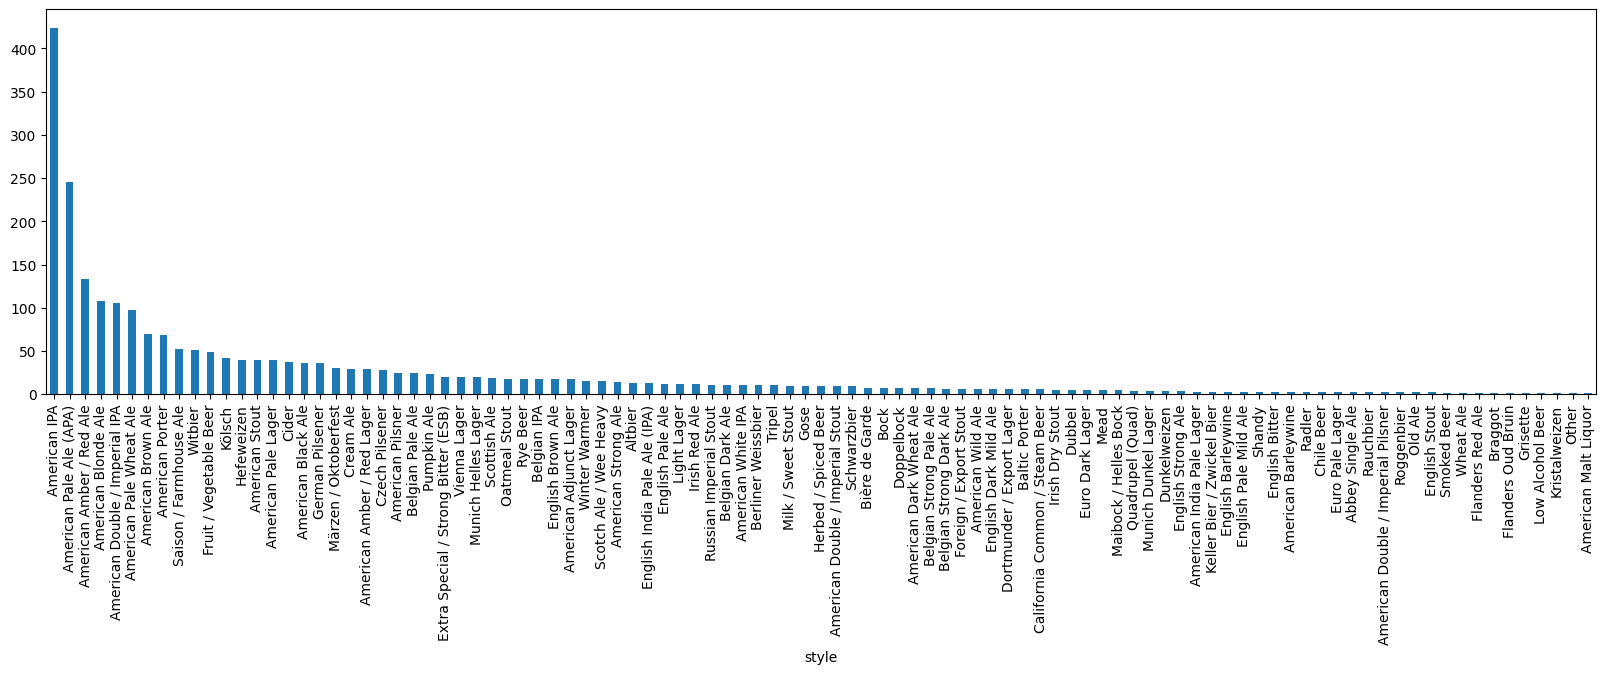

In [4]:
# remove beers with no style or name
craft_beer = craft_beer[~craft_beer['style'].isna()]
craft_beer = craft_beer[~craft_beer['name'].isna()]
# make style a categorical
craft_beer['style'] = pandas.Categorical(craft_beer['style'])
# and draw a picture
counts = craft_beer['style'].value_counts()
fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot(1, 1, 1)
counts.plot(kind='bar')

What we can very quickly see is that we have lots of different beer styles, and many of them have very few samples. To make our task a bit easier, and our confusion matrices a little easier to read, we'll pick a threshold and only keep beers with at least that many samples.

Feel free to play with this value and see what happens in your own time.

<Axes: xlabel='style'>

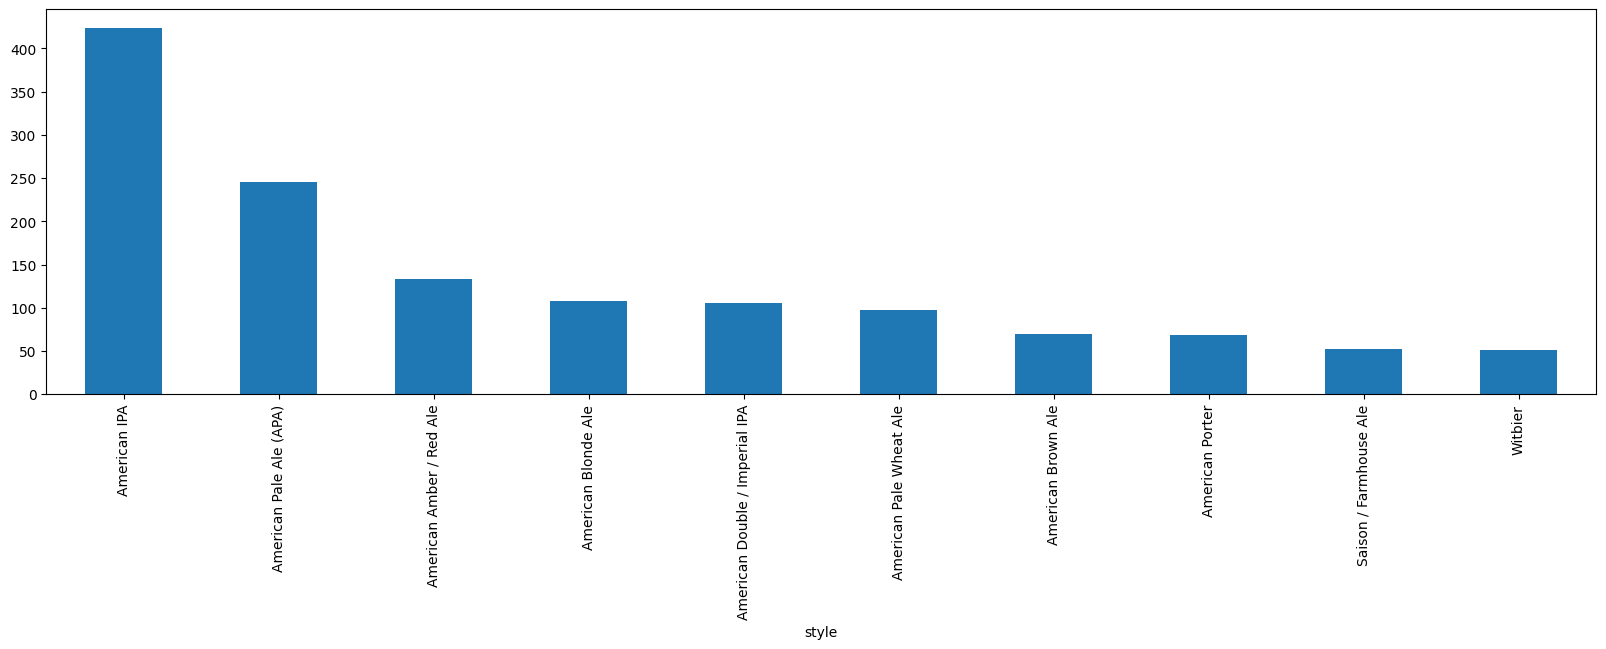

In [5]:
# remove some beers that are rare
threshold = 50
to_remove = counts[counts <= threshold].index
# remove the beers, then remove the now unloved categories
craft_beer = craft_beer[~craft_beer['style'].isin(to_remove)]
craft_beer['style'] = craft_beer['style'].cat.remove_unused_categories()
craft_beer.reset_index(inplace=True)
# and draw another picture
counts = craft_beer['style'].value_counts()
fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot(1, 1, 1)
counts.plot(kind='bar')

This is still massivley unbalanced (but also makes sense in terms of the styles), but we now have a more manageable 10 classes, and for all those classes we have at least some data to learn off.

We're now at the point where we need to convert our beer names into vectors. Let's do that.

In [6]:
# store as list of names
names = []
for n in craft_beer['name']:
    # strip out punctuation
    names.append(n.translate(str.maketrans('', '', string.punctuation)))
    
# store as list of lists of words
names_tokens = []
for n in names:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", n.lower()).split()
    names_tokens.append(tokens)

# have a look at the results
print(names_tokens[1:50])

[['rise', 'of', 'the', 'phoenix'], ['sinister'], ['sex', 'and', 'candy'], ['lake', 'street', 'express'], ['foreman'], ['jade'], ['cone', 'crusher'], ['sophomoric', 'saison'], ['regional', 'ring', 'of', 'fire'], ['garce', 'sel'], ['bitter', 'bitch'], ['bitter', 'american'], ['21st', 'amendment', 'ipa', '2006'], ['brew', 'free', 'or', 'die', 'ipa', '2008'], ['brew', 'free', 'or', 'die', 'ipa', '2009'], ['hop', 'crisis'], ['bitter', 'american', '2011'], ['brew', 'free', 'or', 'die', 'ipa'], ['bimini', 'twist'], ['beach', 'blonde'], ['rod', 'bender', 'red'], ['send', 'help'], ['cast', 'iron', 'oatmeal', 'brown'], ['reprise', 'centennial', 'red'], ['divided', 'sky'], ['resurrected'], ['contact', 'high'], ['galaxyfest'], ['citrafest'], ['scarecrow'], ['rude', 'parrot', 'ipa'], ['ballz', 'deep', 'double', 'ipa'], ['jockamo', 'ipa'], ['citra', 'ass', 'down'], ['the', 'brown', 'note'], ['citra', 'ass', 'down'], ['a', 'beer'], ['rico', 'sauvin'], ['coq', 'de', 'la', 'marche'], ['pile', 'of', 'fa

We have now converted each of our beer names, what was a simple string, into a list of tokens. Each token is a single word. We have converted all those to lower case, and removed any punctuation.

At this point we are ready to convert our words into vectors. We could so this a few ways, one of which is to load a pre-trained model, and if you're interested then [over here](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py) provides some info on doing that. You will also notice that to do that, you will need about 2GB to store the pre-trained model, and so in the spirit of not overloading everyones computers with Word2Vec models you will only use once, we won't do that. 

Instead, let's train our own word to vec model. But why would we do this?
* Because we can.
* To ensure that all of our words are actually in the wordvec model, and so we can actually get a vector representation for each.

The other thing to consider is will this work better? Maybe, but my money is on not. Training our own word2vec model has the big advantage that it can capture the relationships that exist in our text corpus, so perhaps there are relationships that exist in beer names that don't exist in regular text. Training our own model would help with that. The catch is that we have not very much data, so we probably won't be able to learn a very good model, even if it is specific to our task.

Interestingly, there's also a doc2vec model in gensim, would could also be of interest here. But this is not the main event in this example and we're already getting sidetracked.

Anyway, let's train a model.

In [7]:
# train the model
embedding_size = 50
# note that we're going to include every word by setting min_count to 1, this means that even if the word only 
# occurs once, it will be in our model. This is perhaps not the best approach, but we have too small of a corpus
# to go ruling rare words out (they're all rare for us - which does again raise those questions of if we should 
# train our own model or not)
word_model = Word2Vec(sentences=names_tokens, vector_size=embedding_size, window=3, min_count=1, workers=4, sg=0)
# get the embedding for a word that's in our vocabulary
print(word_model.wv['ale'])

[ 0.00097988 -0.00102134  0.00941876  0.01704989 -0.02157463 -0.03303296
  0.02303781  0.03459011 -0.02269954 -0.01720085  0.02230058 -0.01883087
 -0.00987009  0.01798275 -0.01019033  0.00910719  0.01664476  0.01103541
 -0.03423954 -0.02957772  0.01481457  0.0165451   0.03117029 -0.00610609
  0.0149748  -0.0015432  -0.00584715  0.01615594 -0.01983814 -0.00851359
 -0.00739084 -0.00956742  0.01977955 -0.01117031 -0.00585305  0.00047725
  0.03078211 -0.0127198   0.00190915 -0.01402882 -0.01001568  0.00686522
 -0.02077807 -0.00906527  0.02077724  0.00030987 -0.01647737  0.01053043
  0.01532283  0.02563019]


The above is the vector representation of the word ale.

Now we need to get some vectors for all of our documents. What we can do is loop through all of our samples, convert each word, and then just append the vectors. One issue we will have is that not all beers have the same number of words in their names. A beer with a two word name will have a 100 dimension representation (assuming we keep our 50 dim Word2Vec model), while a beer with 6 words will have 300 dimensions.

This is a problem as all of our classification models (and the vast majority of machine learning models in general) expect inputs to be a constant size. We'll address this by picking a maximum number of words, and only considering beers with that number of words or less. For beers with fewer words, we'll add zeros to the vector to achieve a standard length.

**NOTE:** Here I'm also going to pull out the original names for the beers that are in our final training and test sets. I'm going to use this later, but for convenience and to make sure that I get the correct data, I'm grabbing this here.

In [8]:
max_words = 6
X = []
X_names = []
Y = []
for i,n in enumerate(names_tokens):    
    v = numpy.zeros(embedding_size*max_words)
    if (len(n) <= 6):
        for j,w in enumerate(n):
            v[j*embedding_size:(j+1)*embedding_size] = word_model.wv[w]
        X.append(v)
        Y.append(craft_beer['style'][i])
        X_names.append(names[i])

We now have converted most of our data to vectors (we've lost beers with really long names).

Finally we can do our data split. There's a function in sklearn that will do that for us.

In [9]:
X_train, X_test, X_train_names, X_test_names, Y_train, Y_test = train_test_split(X, X_names, Y, test_size=0.3, random_state=1)

print(numpy.shape(X_train))
print(numpy.shape(X_train_names))
print(numpy.shape(Y_train))
print(numpy.shape(X_test))
print(numpy.shape(X_test_names))
print(numpy.shape(Y_test))

(938, 300)
(938,)
(938,)
(403, 300)
(403,)
(403,)


And that is one approach of how we can go from text to numbers for an ML problem. There are some obvious issues with this approach though. In brief:
* We've thrown away a number of samples that had too many words in them. Discarding data is never ideal.
* We've made the order of words very critical to our model. For example, we have two beers called 'Red Ale' and 'Another Red Ale', chances are they are fairly similar. But the two vector representations will be very different, as the numbers that correspond to 'Red Ale' will lie in different parts of the overall length 300 vector. In some cases this could be good, in other cases this could be bad.
* We've used our own Word2Vec model, which is, in all likelihood, not as rich as a large pre-trained model.

We'll put all that to one side though and get on with the classification.

## Multi-Class K-Nearest Neighbours
We'll start with our KNN classifier. To use this with multi-class data we do.... nothing. It does it out of the box.
As per usual, with a CKNN we need to be careful with our number of neighbours which can have a big impact on results.

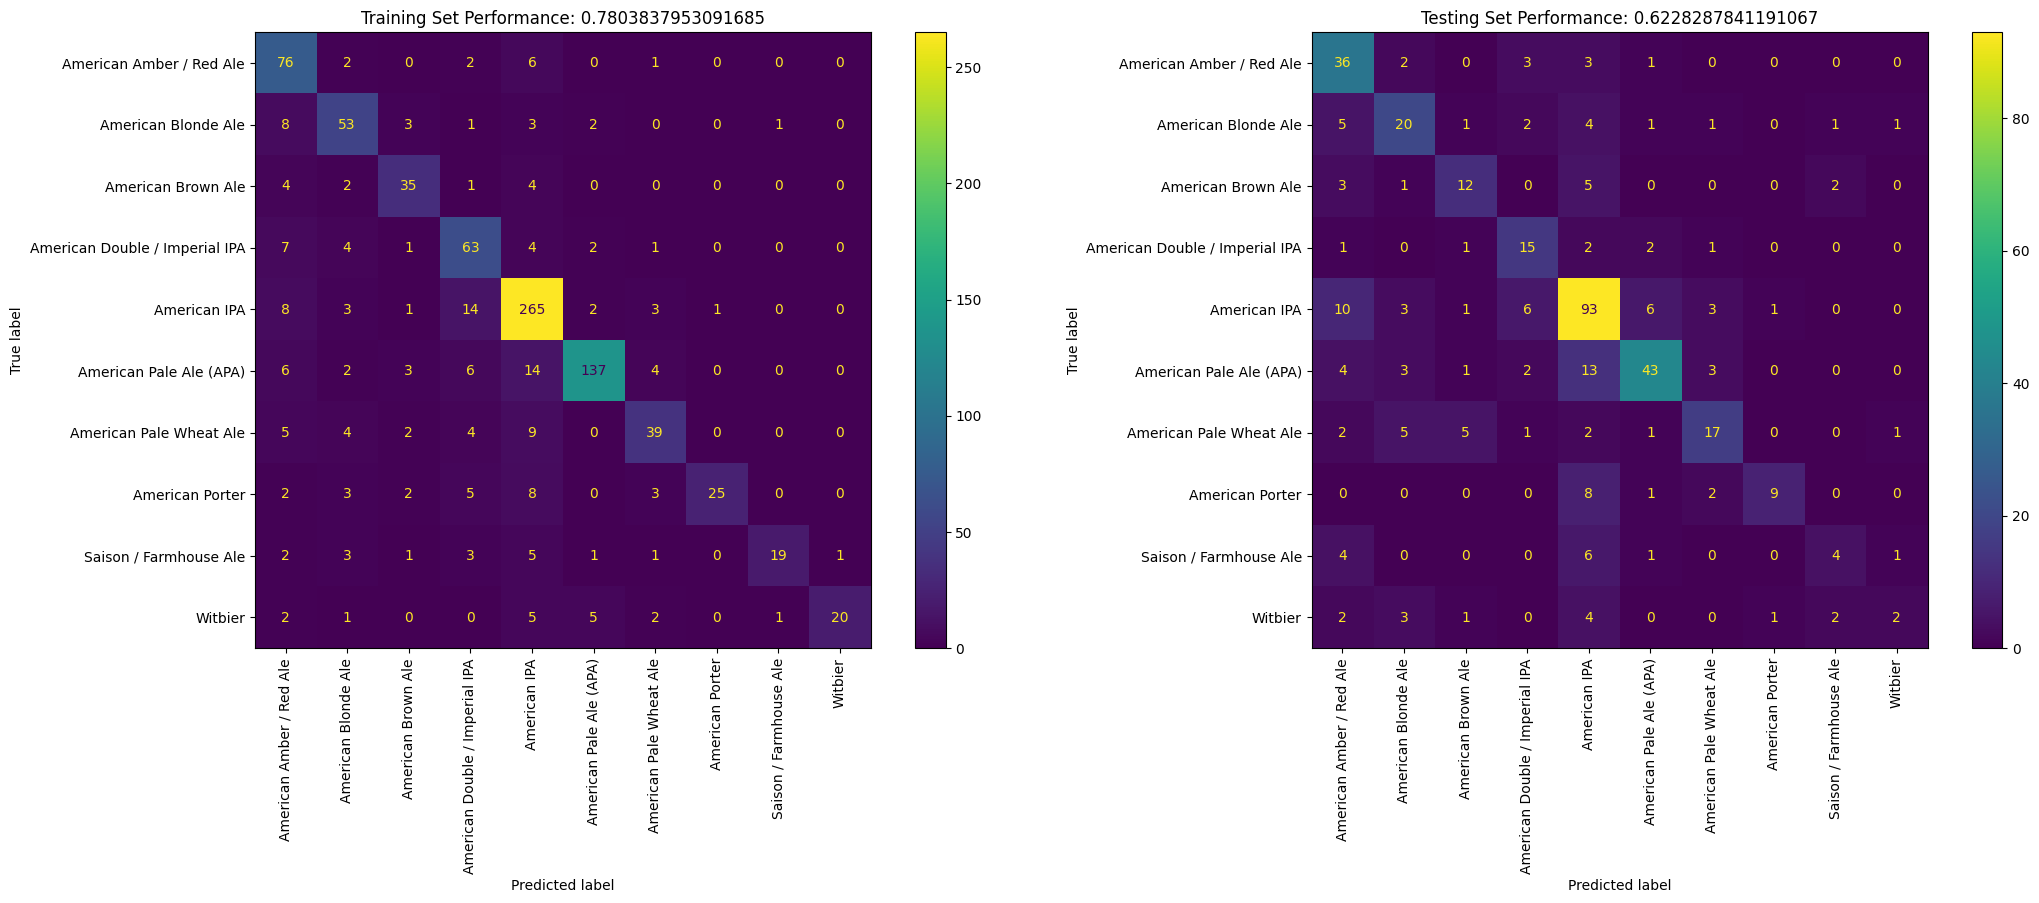

In [10]:
# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));

cknn = KNeighborsClassifier(n_neighbors=3)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

Before we go too far, let's look at the more complex confusion matrix. Note that this time in order to make the class imbalance clear, we're showing sample counts rather than percentages. Ideal performance is too only have numbers along the top-left to bottom-right diagonal. Remember that:
* the true class is on the vertical axis
* the predicted class is on the horizontal axis

Let's consider the top row (American Amber). On the testing set, we can see that:
* 35 instances are correctly classified
* 2 instances are classified as a Blonde Ale
* 2 instances are classified as an Imperial IPA
* 3 instances are classified as a Pale Ale
* 1 instance each is classified as an IPA, a Wheat Ale and a Poter 

On the whole, we get 35 right, and 10 wrong. Critically, we can see where we make the errors, with most of the confusion actually spread pretty well amongst the other beers. By using the raw counts rather than percentages, it also clearer which classes we have limited data for (witbier for example).

On the whole, our classifier is not shocking - ~60% correct for 10 classes is well above random chance. As we've seen before, the number of neighbours is fairly important, and changing that can have a big impact on performance.

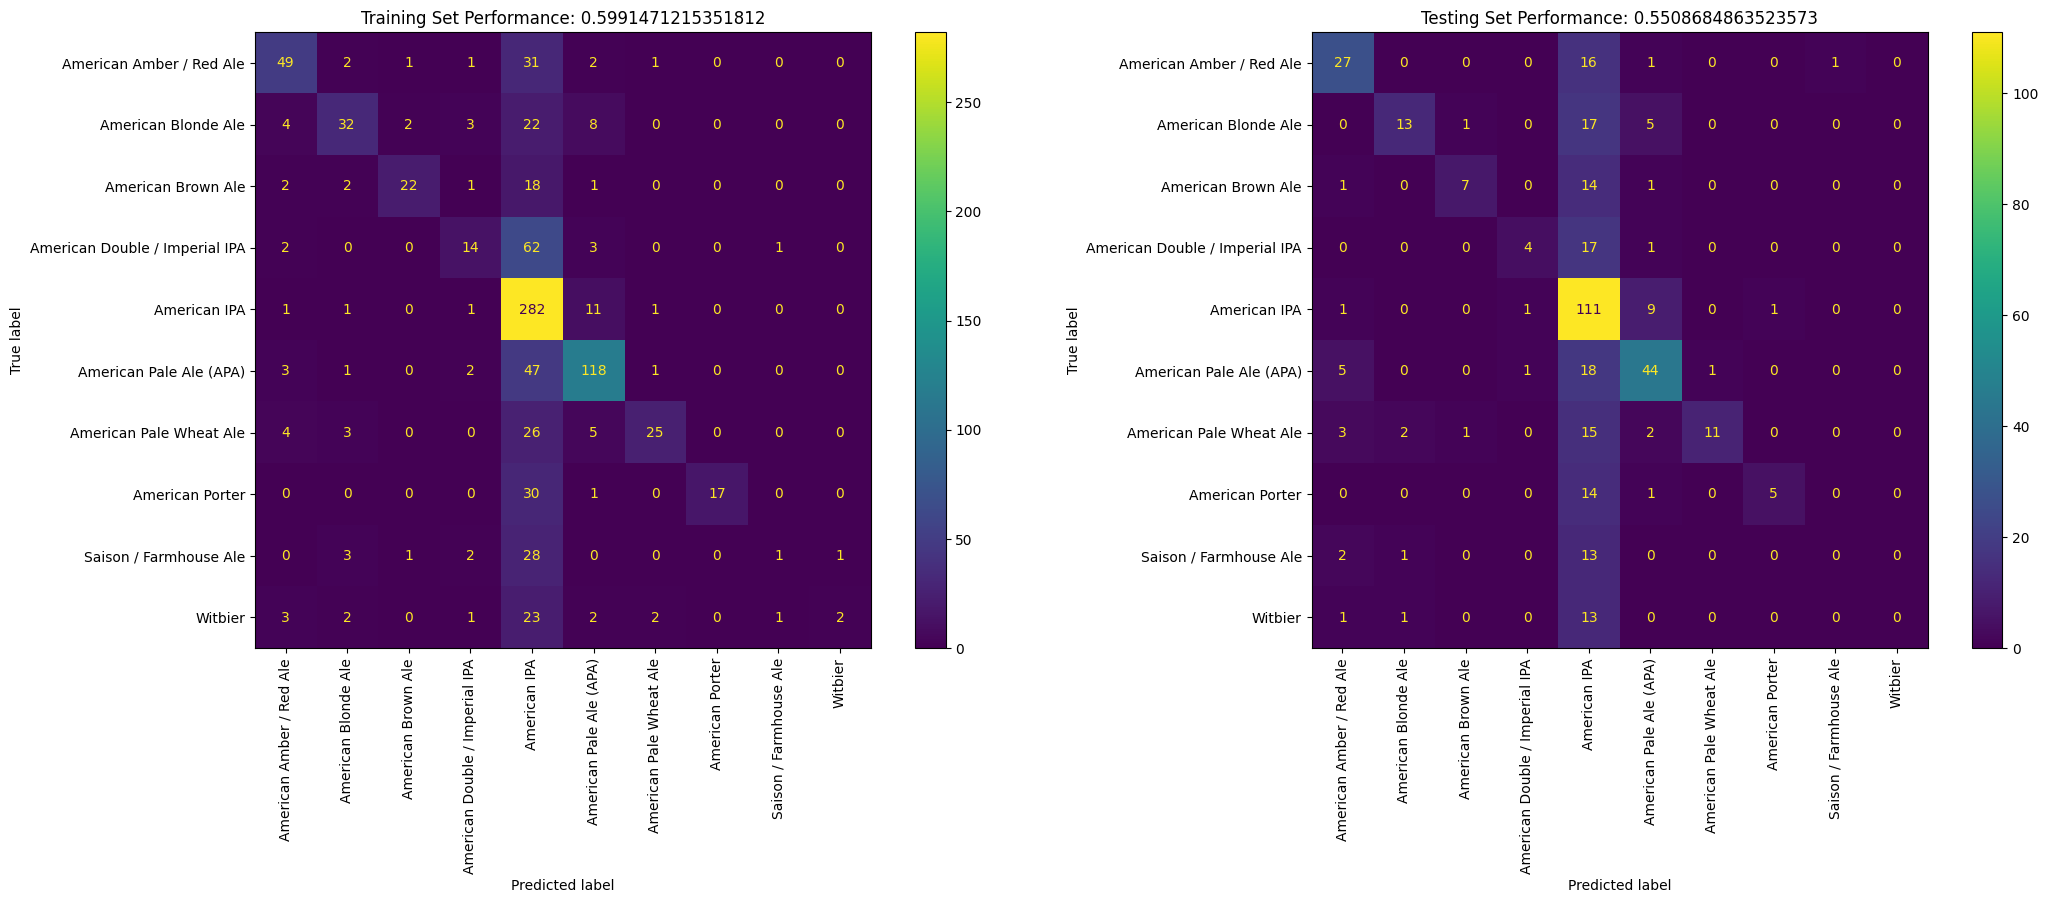

In [11]:
cknn = KNeighborsClassifier(n_neighbors=20)
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

We can see performance has dropped, and in particular has dropped for the classes with fewer instances. One thing we can do to help with the scarce classes is change the way distances are weighted. Normally, a uniform distance is used, i.e. all N neighours are equal. With sklearn, we can use an inverse weighting. This means that points that are closer are worth more. Let's use that.

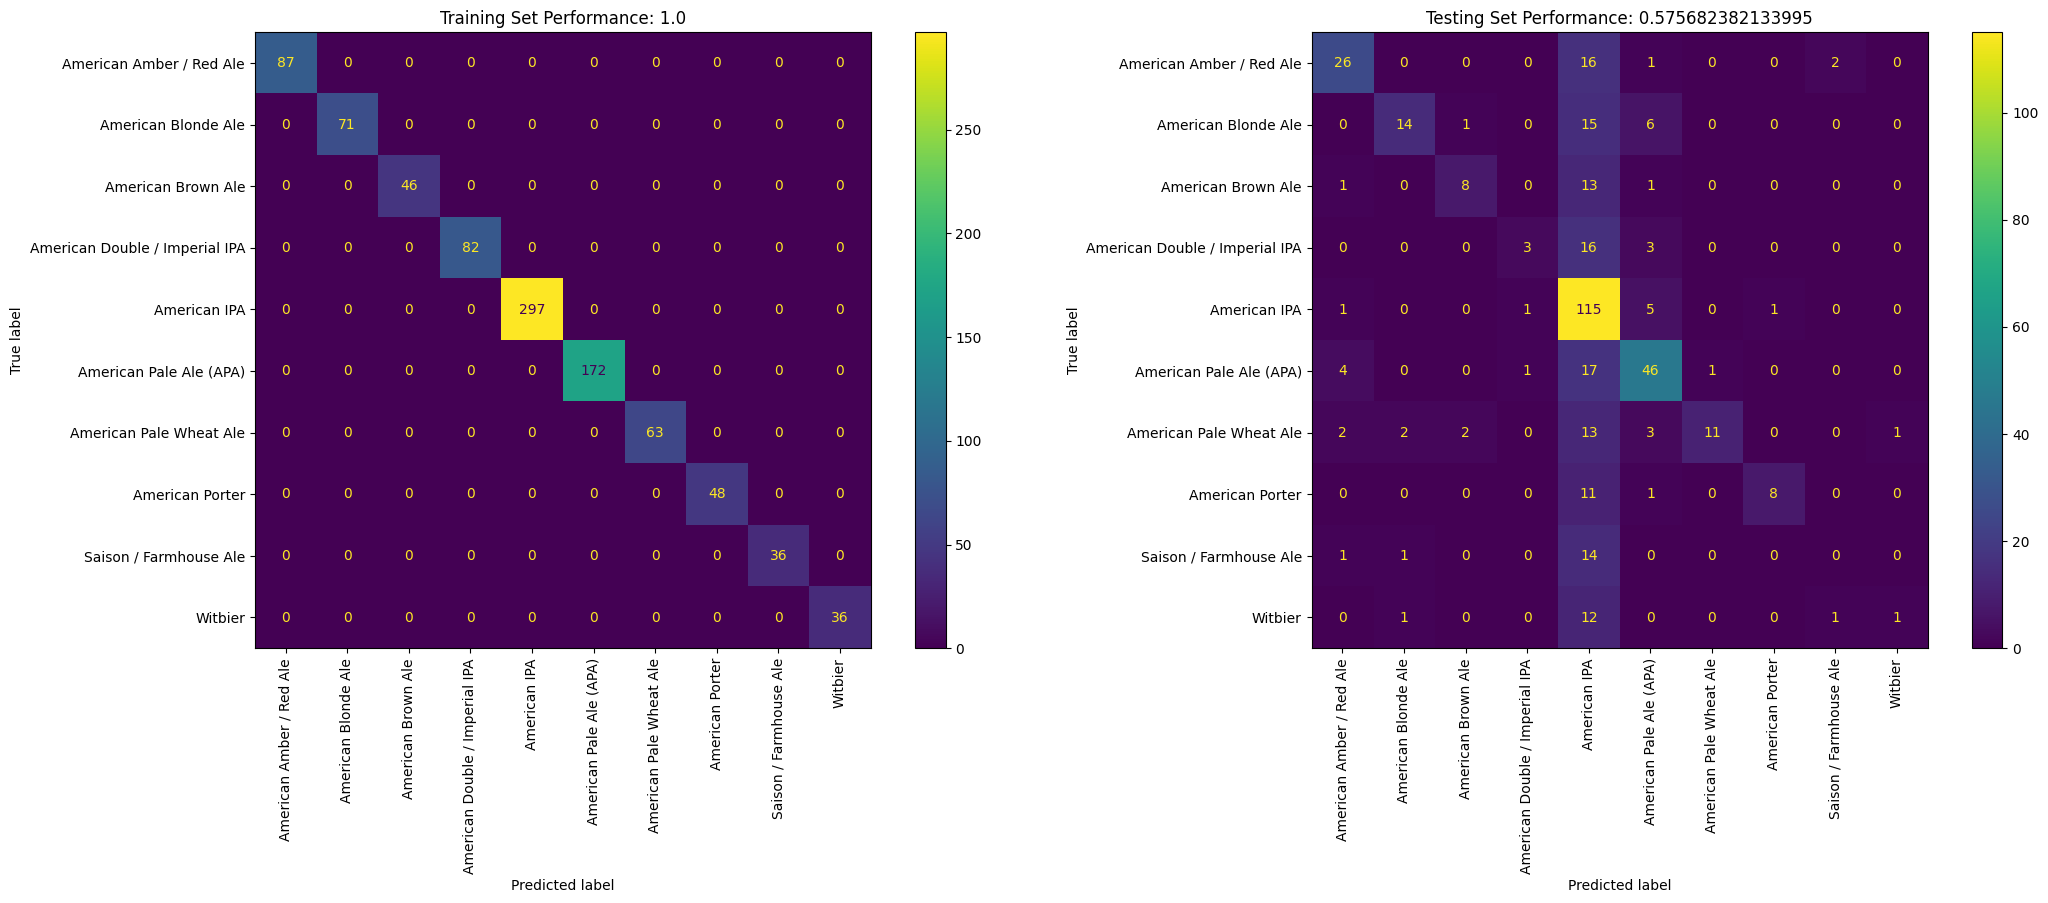

In [12]:
cknn = KNeighborsClassifier(n_neighbors=20, weights='distance')
cknn.fit(X_train, Y_train)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

Our training set is now perfect (becuase the closest point to any sample is sitting directly on top of another point, and so is a distance of 0 away), but we can see that our testing results also get a bit better, which is cool.

There are other hyper-parameters to play with such as the distance metric, but we'll leave those for you to explore in your own time. Chances are you can improve on the performance here further.

## Multi-Class SVMs

SVMs are a binary classifier. The whole idea is finding the magical hyperplane that divides our data into two parts. Therefore, one may think that we need to stuff around a lot to get an SVM working with multi-class data. 

With that in mind, let's throw some multi-class data at an SVM and see what happens.

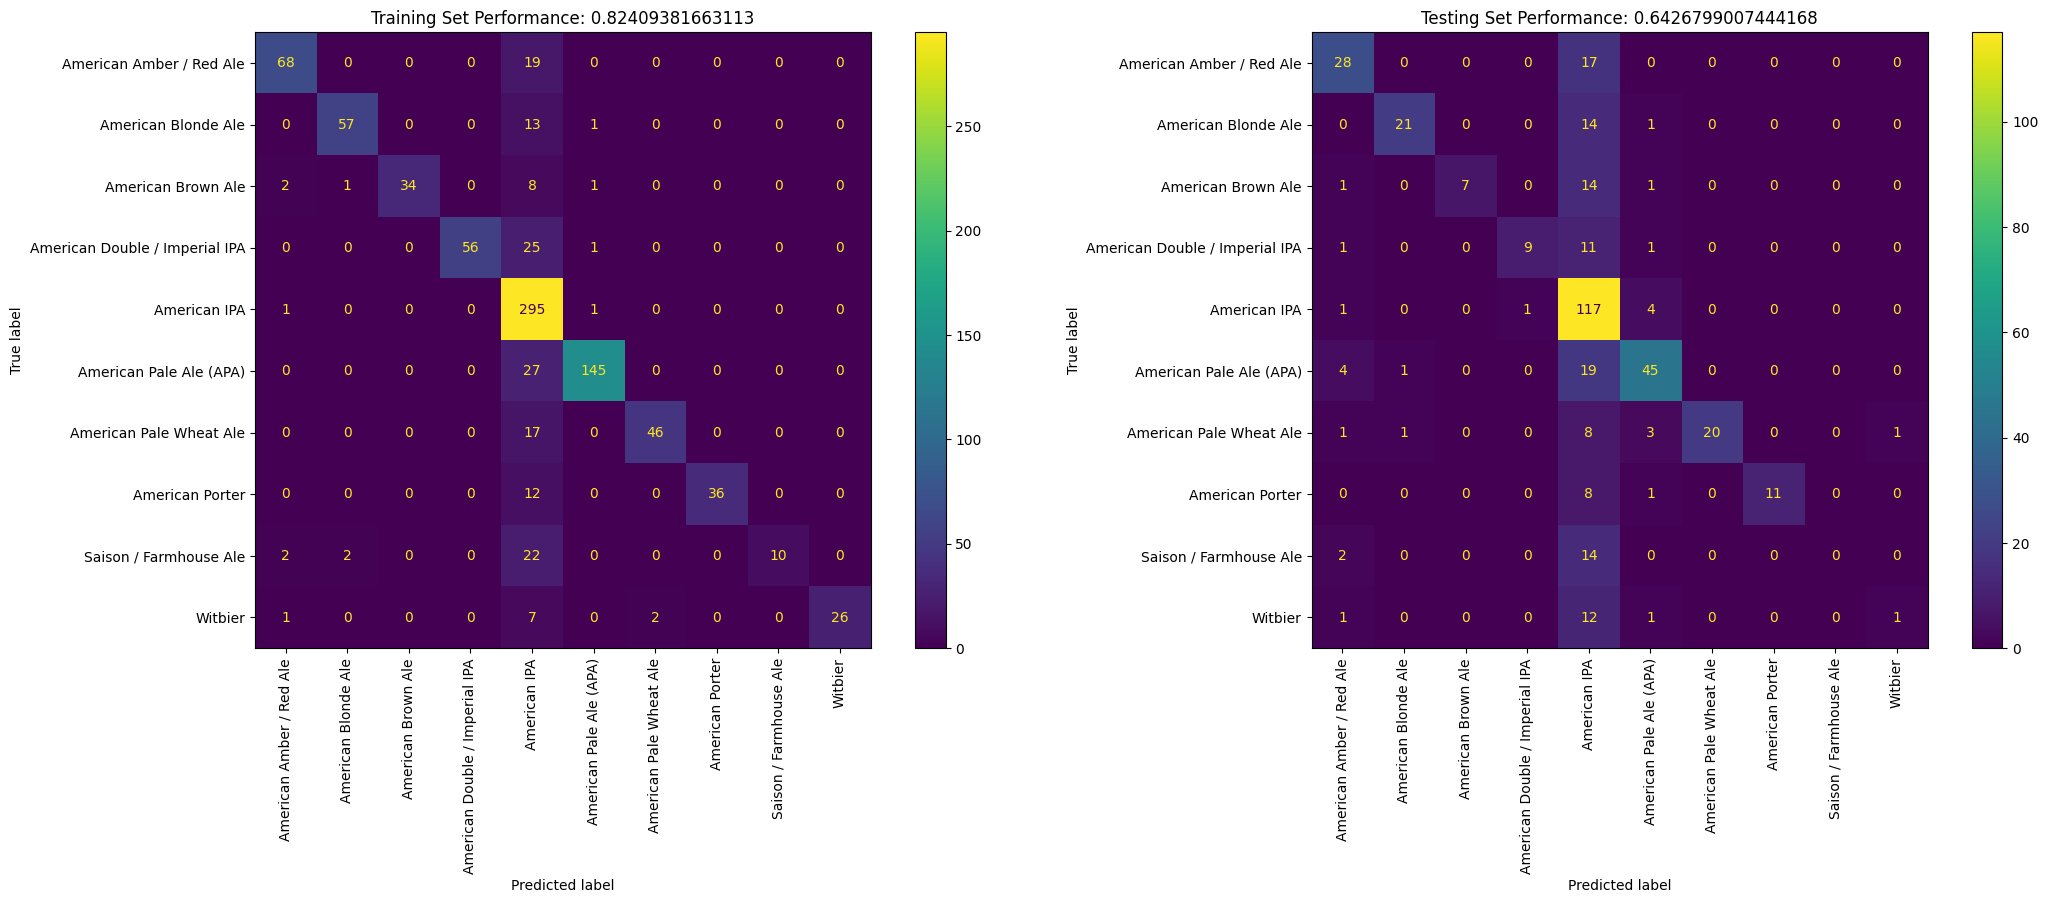

In [13]:
onevsone_svm = OneVsOneClassifier(SVC())
onevsone_svm.fit(X_train, Y_train)
eval_model(onevsone_svm, X_train, Y_train, X_test, Y_test)

Turns out stuffing about is kept to an absolute minimum. But this begs the question, what just happened? The sklearn SVM class will automatically extended itself to a 1v1 encoding when it get's shown multi-class data. It just does this on it's own.

Let's quickly recap what we mean by a 1v1 encoding. This means that we learn an SVM for all the pairs of variables. So we'll have:
* An SVM for American Amber vs American Blone Ale
* An SVM for American Amber vs American Brown Ale
* An SVM for American Amber vs IIPA
* An SVM for American Amber vs IPA
* and so on

This leads to a lot of different SVMs being learnt, and can cause issues with run-times. The alternative is a 1 vs All encoding, which will learn:
* An SVM for American Amber vs Everything Else
* An SVM for American Blonde vs Everything Else
* An SVM for American Brown vs Everything Else
* and so on

This is still a lot of SVMs if we have a lot of classes, but far fewer overall.

This adds a new parameter, $\nu$, which actually replaces our old favourite, $C$. Where as $C$ allowed each point to move some amount such that a perfect fit did not need to be achieved, $\nu$ is an "An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval (0, 1]". So it's just a different way of trading off errors effectivley.

It's worth quickly looking at what happens when we spec our SVMs badly and they won't fit. How does python fail in these cases?

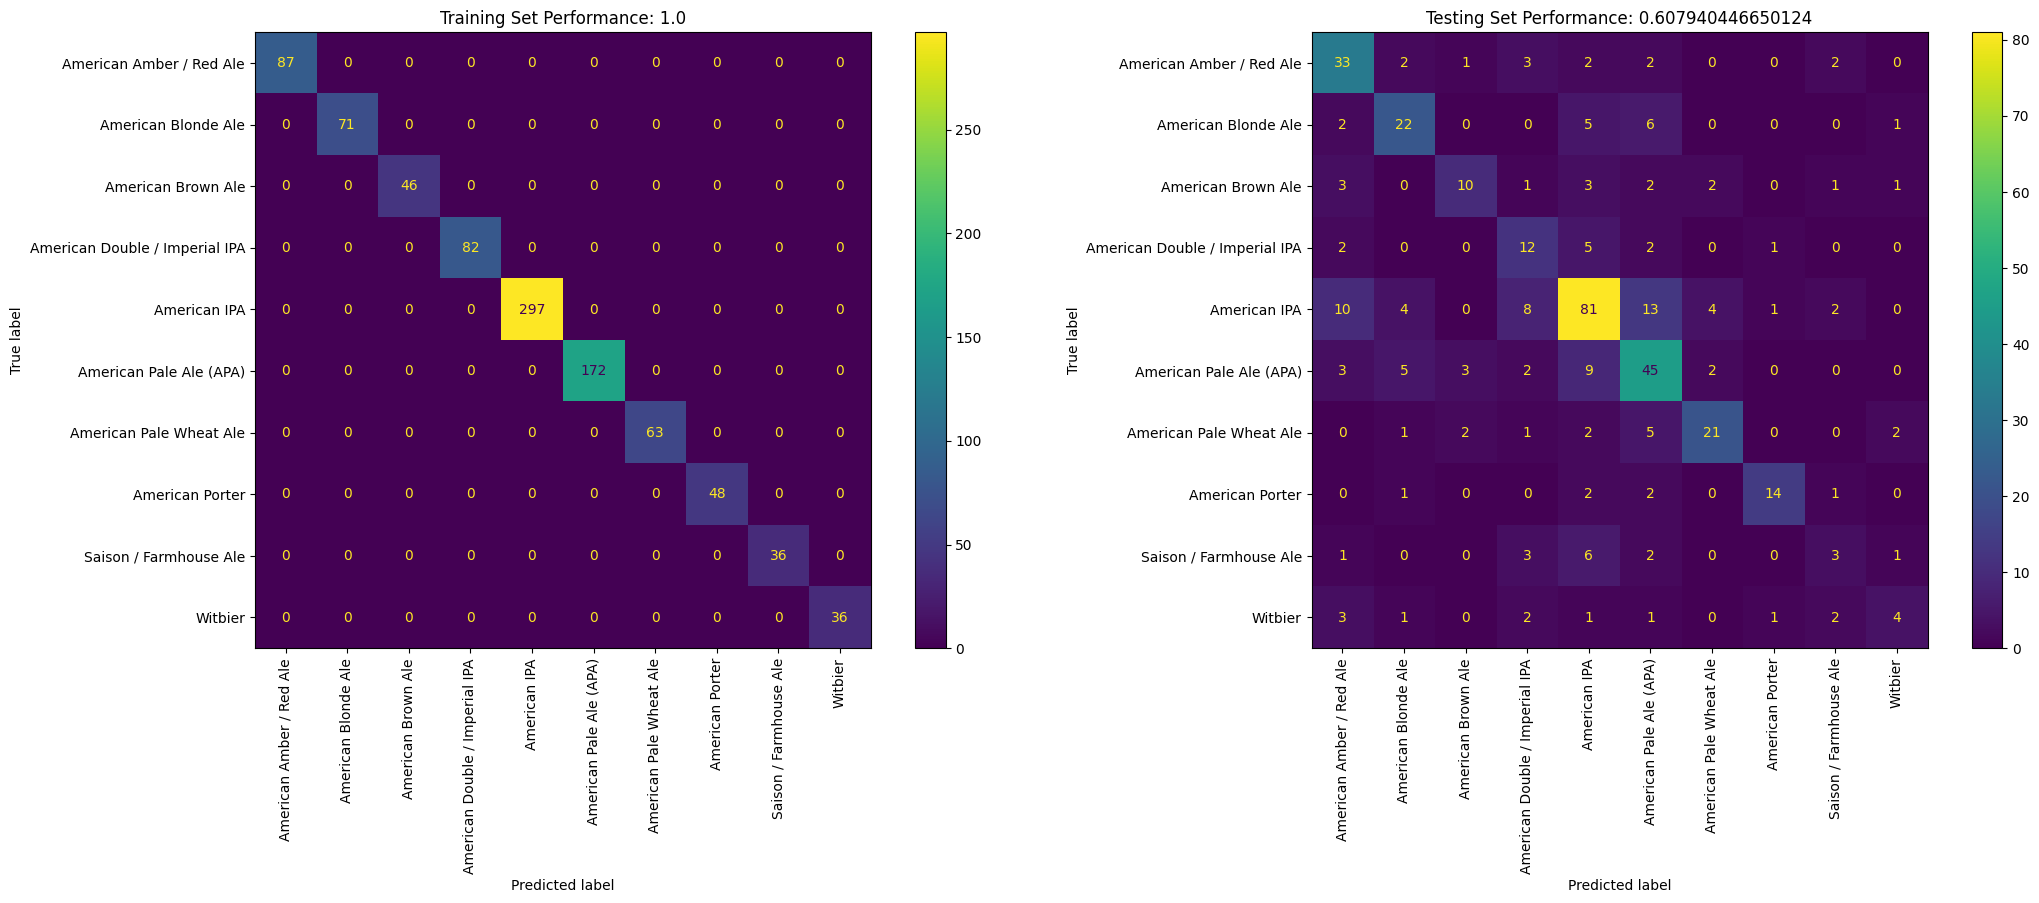

In [14]:
# crank up C, it's 1 by default. Let's go all the way and make it inf. We'll also change the 
# kernel to linear. It's an RBF by default
onevsone_svm = OneVsOneClassifier(SVC(C = inf, kernel='linear'))
onevsone_svm.fit(X_train, Y_train)
eval_model(onevsone_svm, X_train, Y_train, X_test, Y_test)

Perhaps surprisingly, this still works. While it may seem that for a regular SVM, having a linear kernel and $C=\inf$ should kill it, keep in mind that in this case we have 300-dimensional data (and it's only that small becuase we have a word embedding of size 50), so there's a lot of space there to find a hyper-plane. If we had a smaller data space, we could get it to fail.

### One vs All
Let's do the one vs all option now.
All we do is create a multi-class learner and pass it an SVM, then we just do what we've been doing. Slightly more stuffing around than the 1 vs 1 option, but not much.

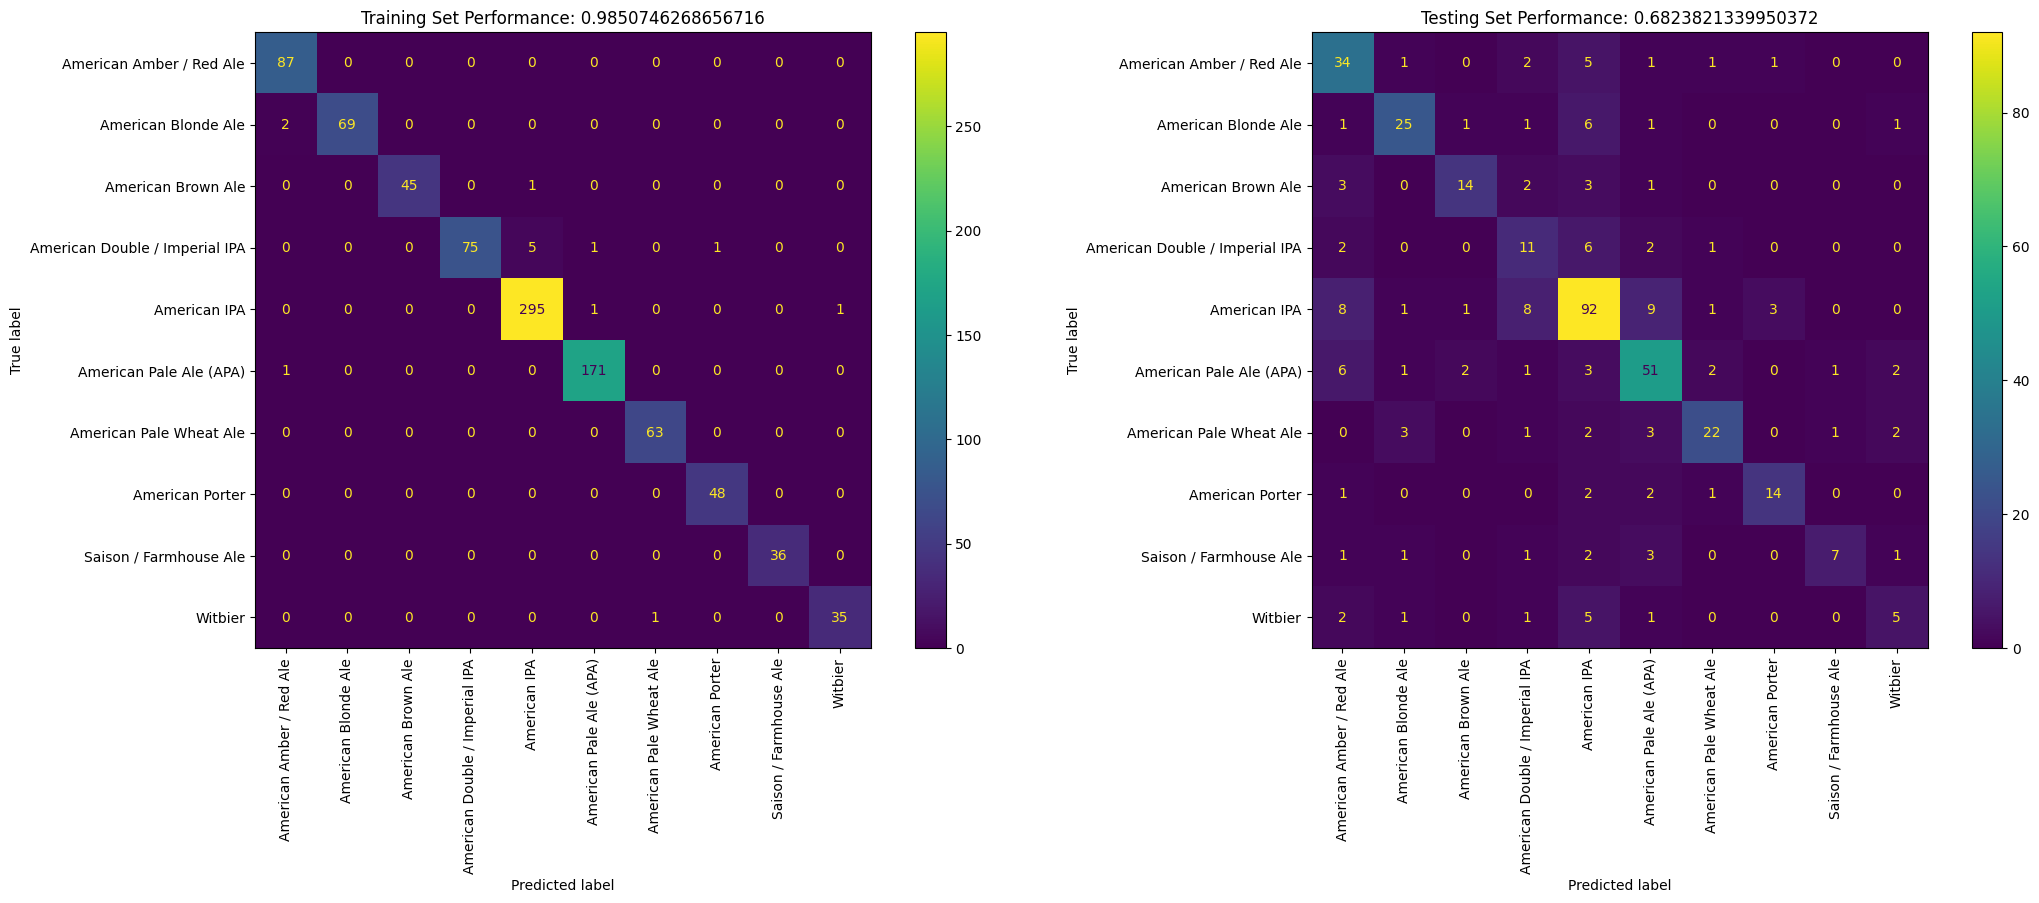

In [15]:
onevsall_svm = OneVsRestClassifier(SVC())
onevsall_svm.fit(X_train, Y_train)
eval_model(onevsall_svm, X_train, Y_train, X_test, Y_test)

### Class Weights

We've mentioned class weights a bit. Let's see how to do that in python.

It's actually really easy to at least set balanced weights, which is normally what we want to do. If we simply set class_weights to 'balanced' python will automatically get class weights based on inverse frequency.

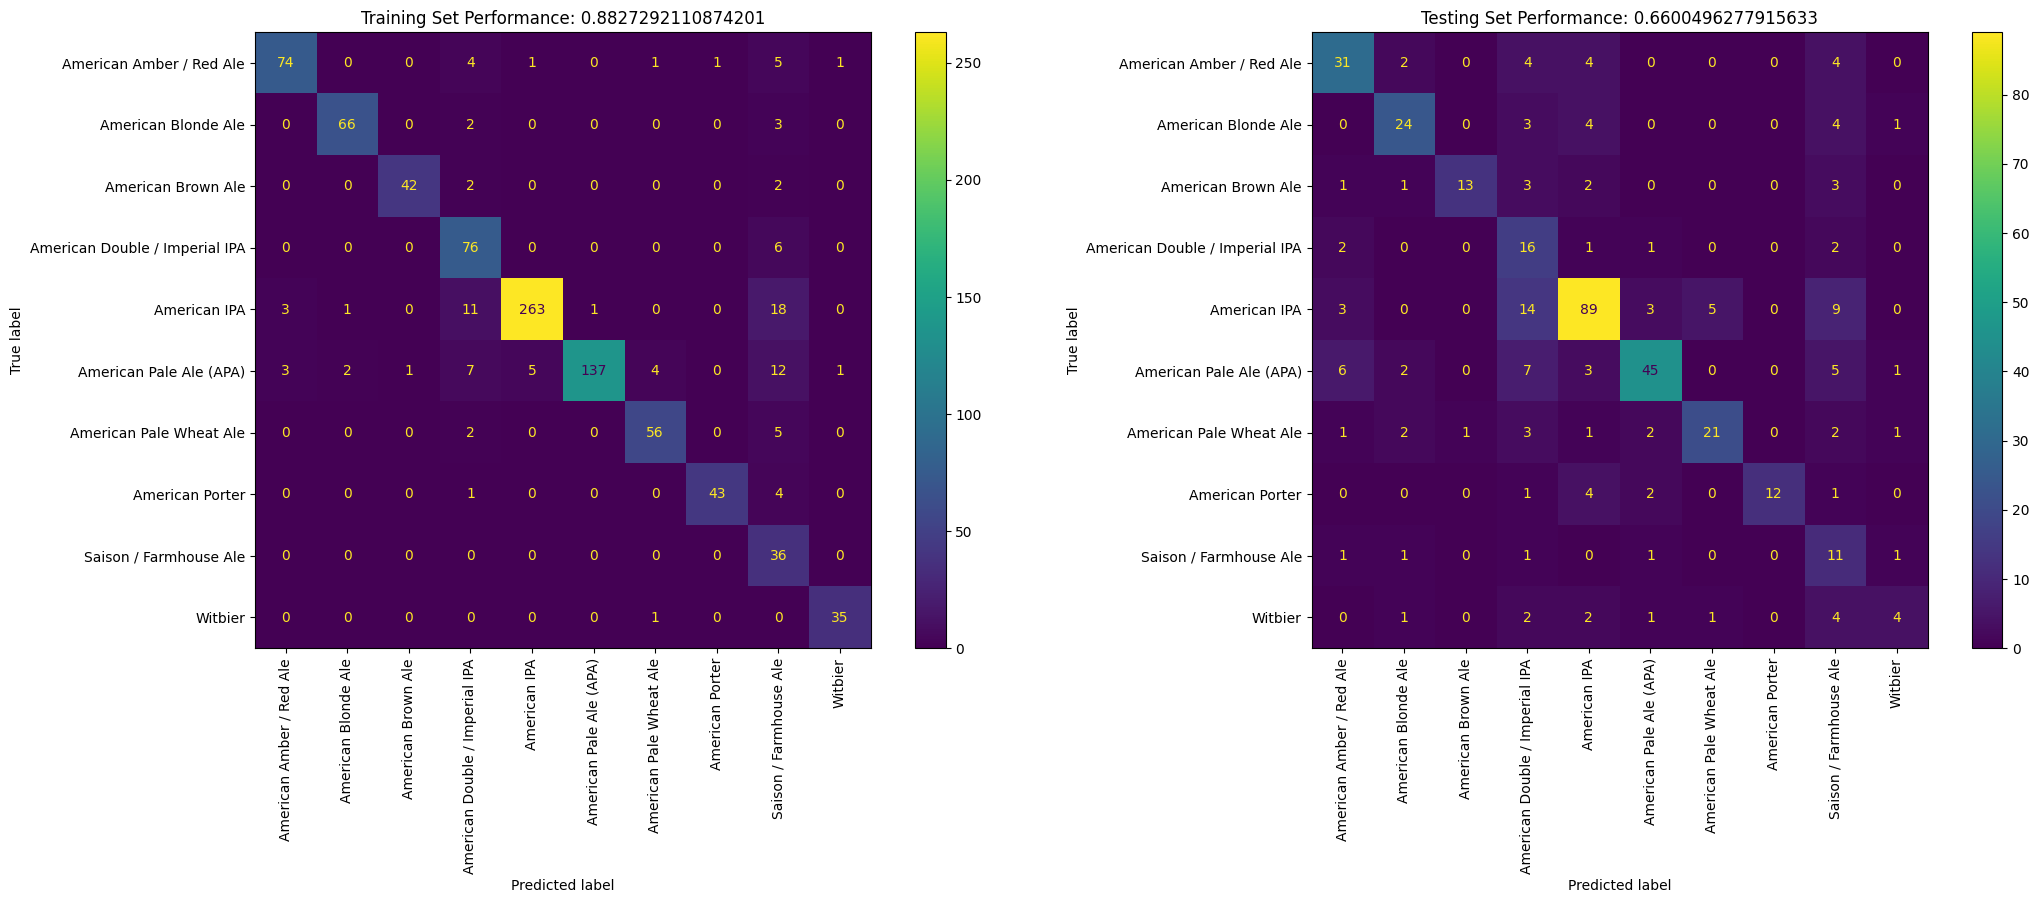

In [16]:
onevsone_svm = OneVsOneClassifier(SVC(class_weight='balanced'))
onevsone_svm.fit(X_train, Y_train)
eval_model(onevsone_svm, X_train, Y_train, X_test, Y_test)

It's pretty much the same for our one-vs-the-rest case too.

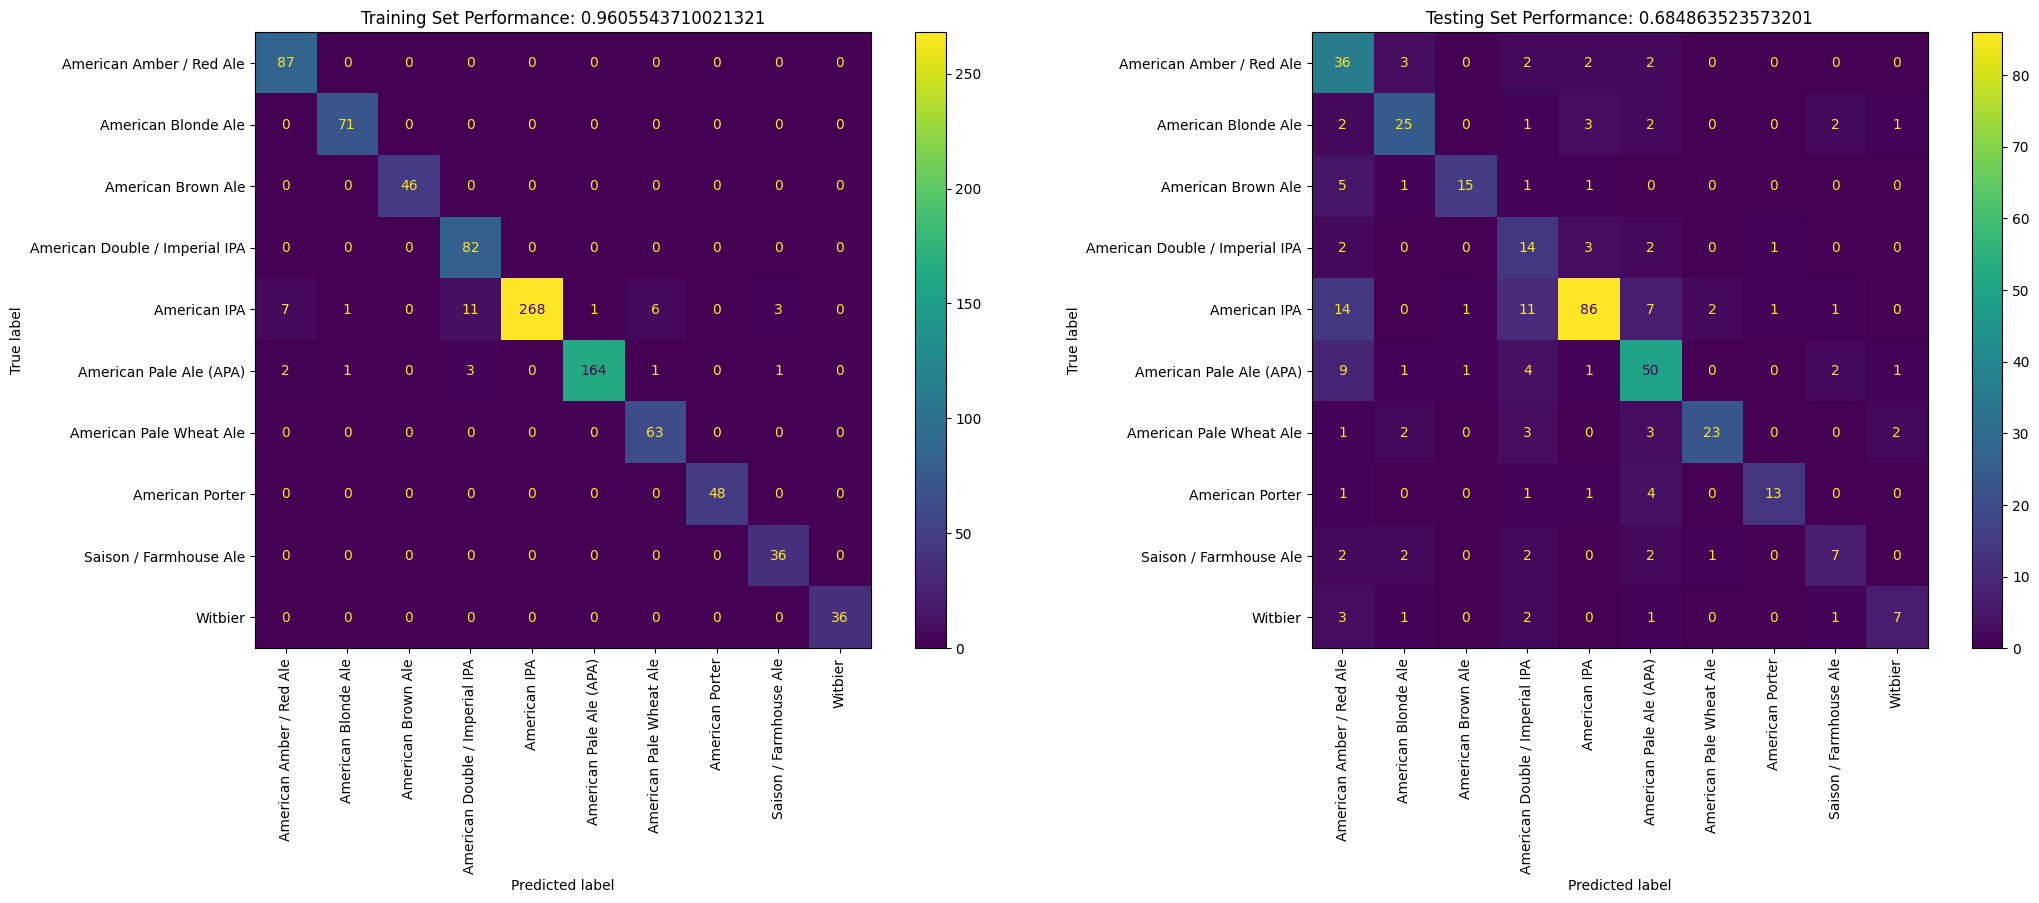

In [17]:
onevsall_svm = OneVsRestClassifier(SVC(class_weight='balanced'))
onevsall_svm.fit(X_train, Y_train)
eval_model(onevsall_svm, X_train, Y_train, X_test, Y_test)

It's worth noting what happens here with our accuracy as we add class weights. We don't necessarily see our overall accuracy go up. We tend to see fewer errors/better performance in the classes with few samples, but we can see lower performance in those classes with lots of samples. As we have many more samples in those popular classes, overall accuracy can in fact go down.

As with the CKNN, we've not fully optimised our SVM here. Feel free to continue to play with this and explore what is possible.

## Random Forests 

Switching to random forests now, and again we have to do nothing to get this running with our multi-class data, and we can see that the model works well compared to our CKNN. We still have issues with class balance, but we can try to address those.

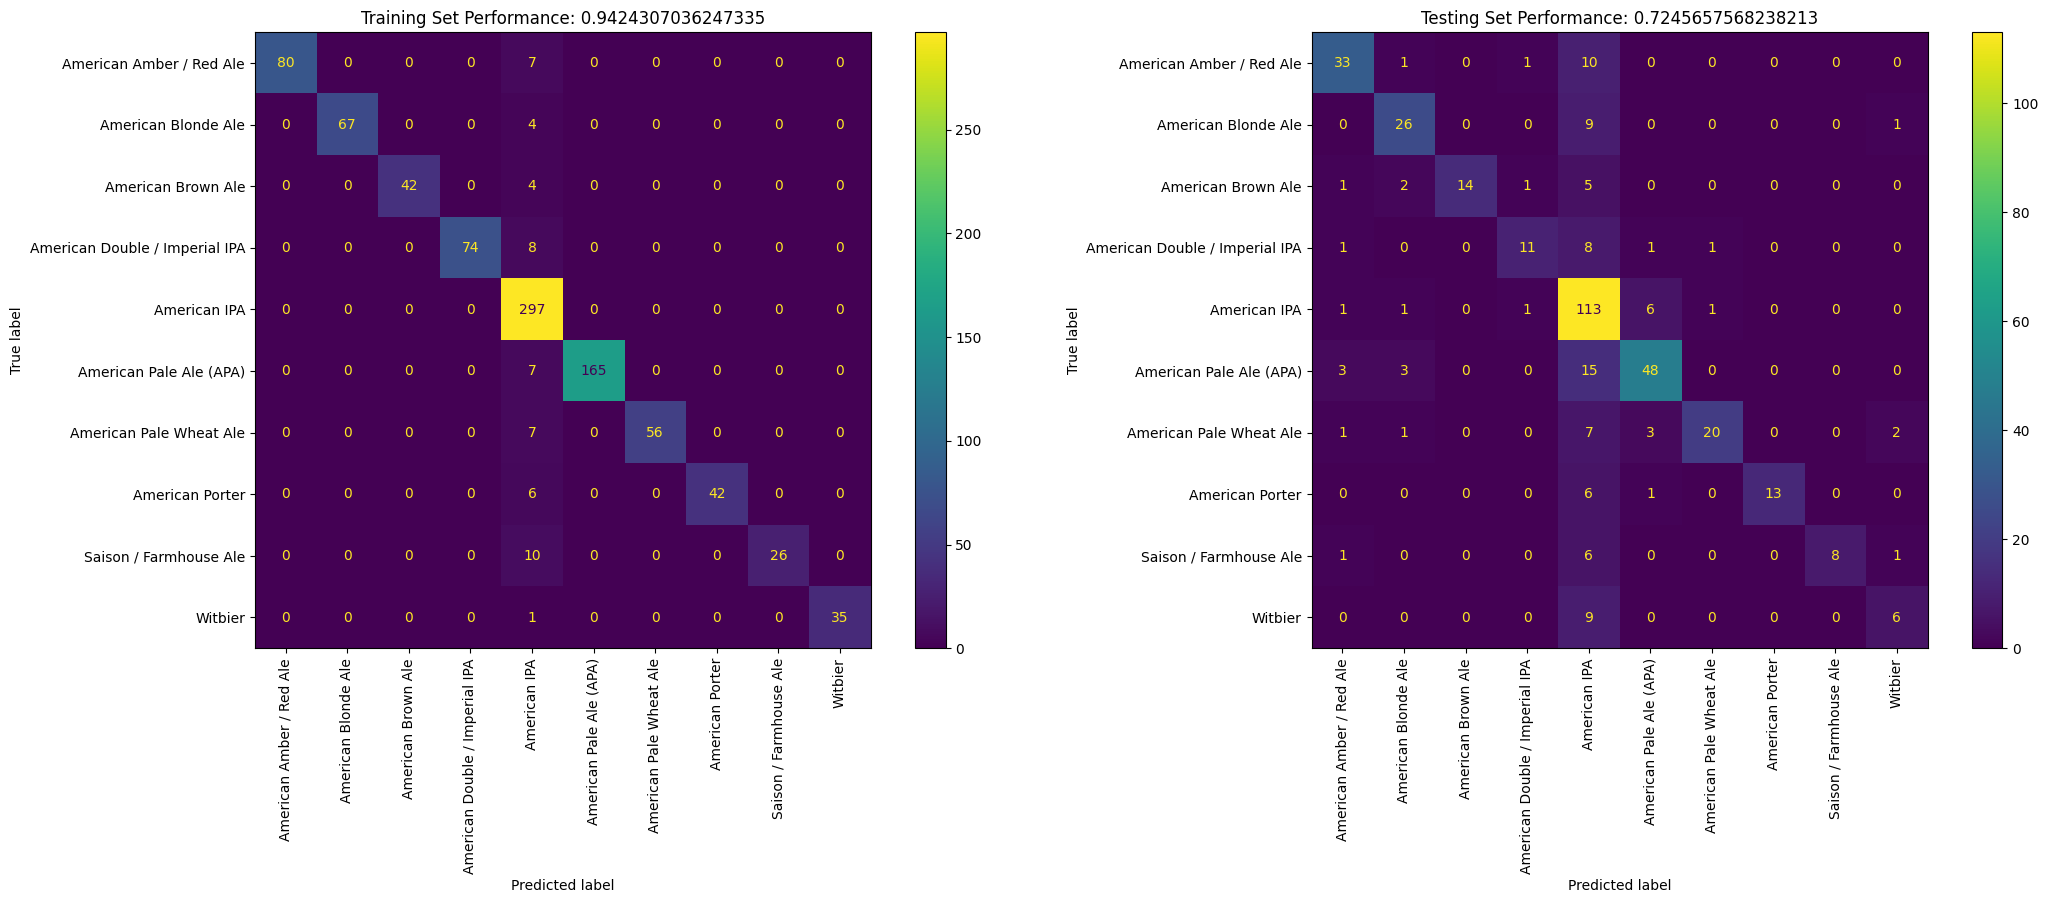

In [18]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0)
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

With the extra classes, there's nothing that we need to do to make this work - but we do need to take care to ensure our trees are deep enough to separate the samples into all the classes. If we have a very low depth we will simply fail to split the data into the 10 classes.

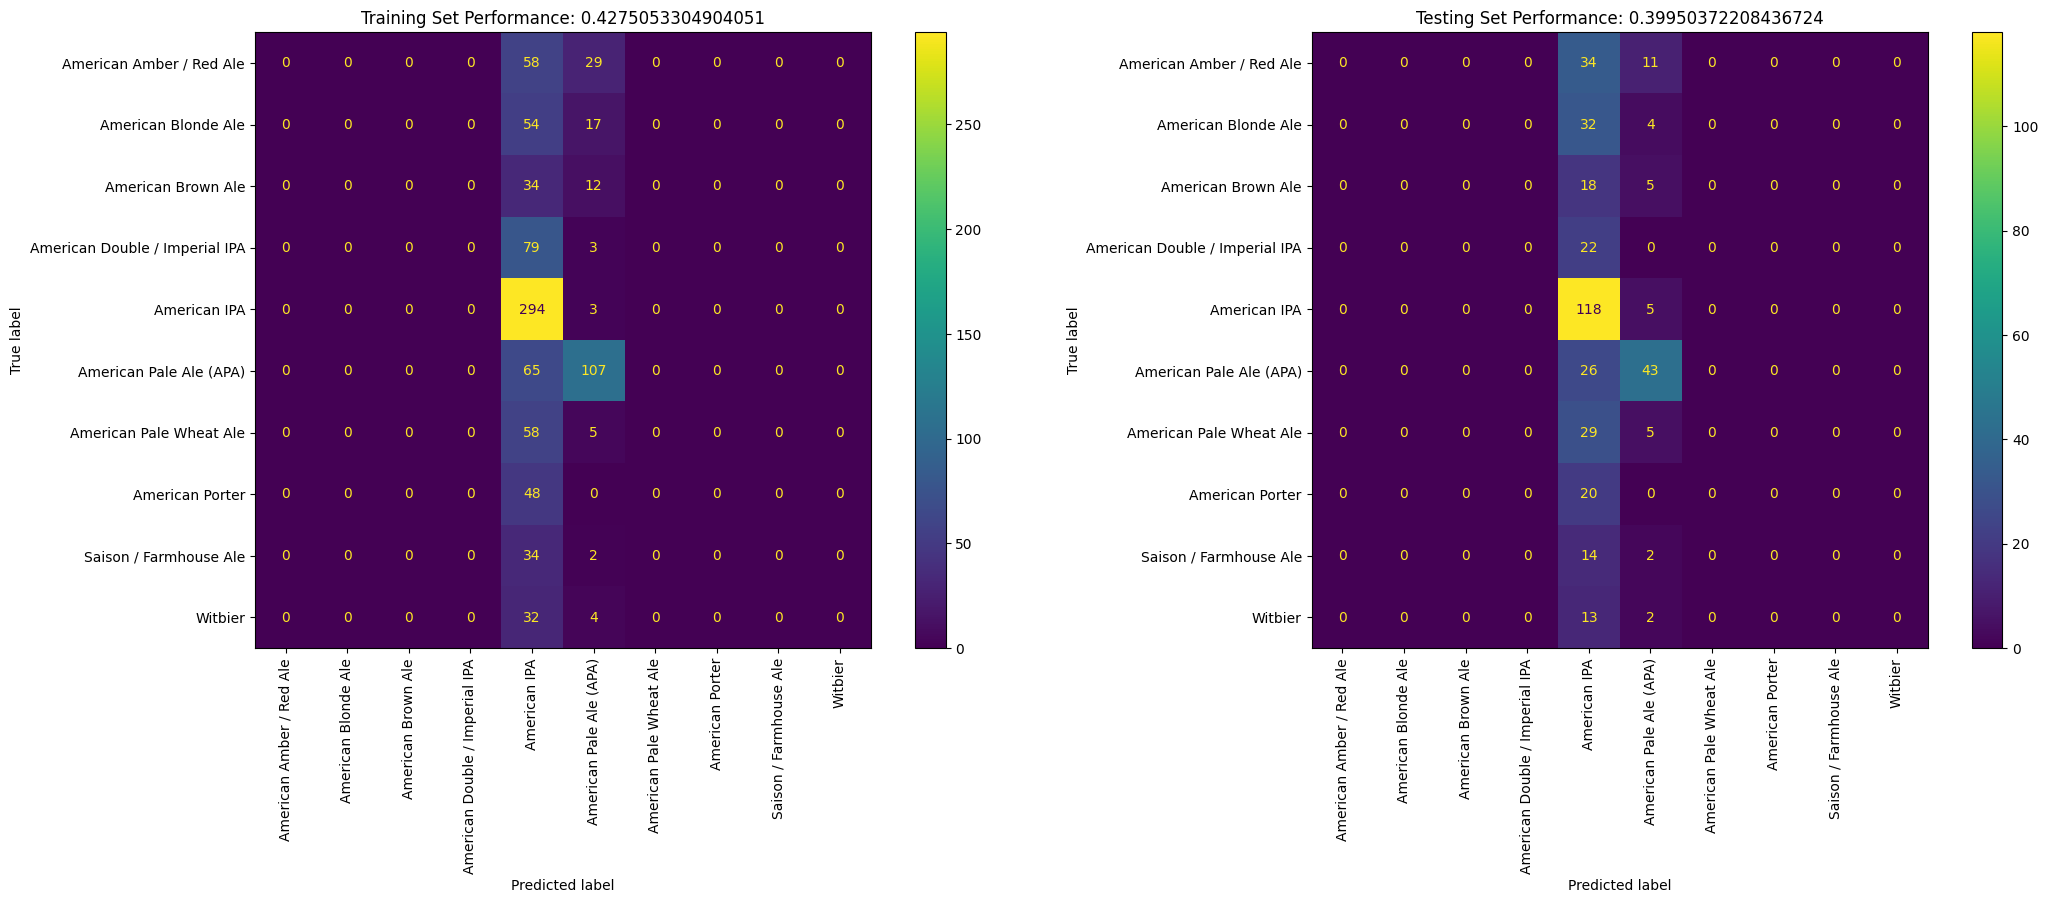

In [19]:
rf = RandomForestClassifier(n_estimators=250, max_depth=2, random_state=0)
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

With a tree depth of two, most (if not all) of the decisision in each of the trees will be regarding the two majority classes. Also, for this depth we only have upto 4 leaves in each tree - so we simply can't split data into 10 classes within a single tree.

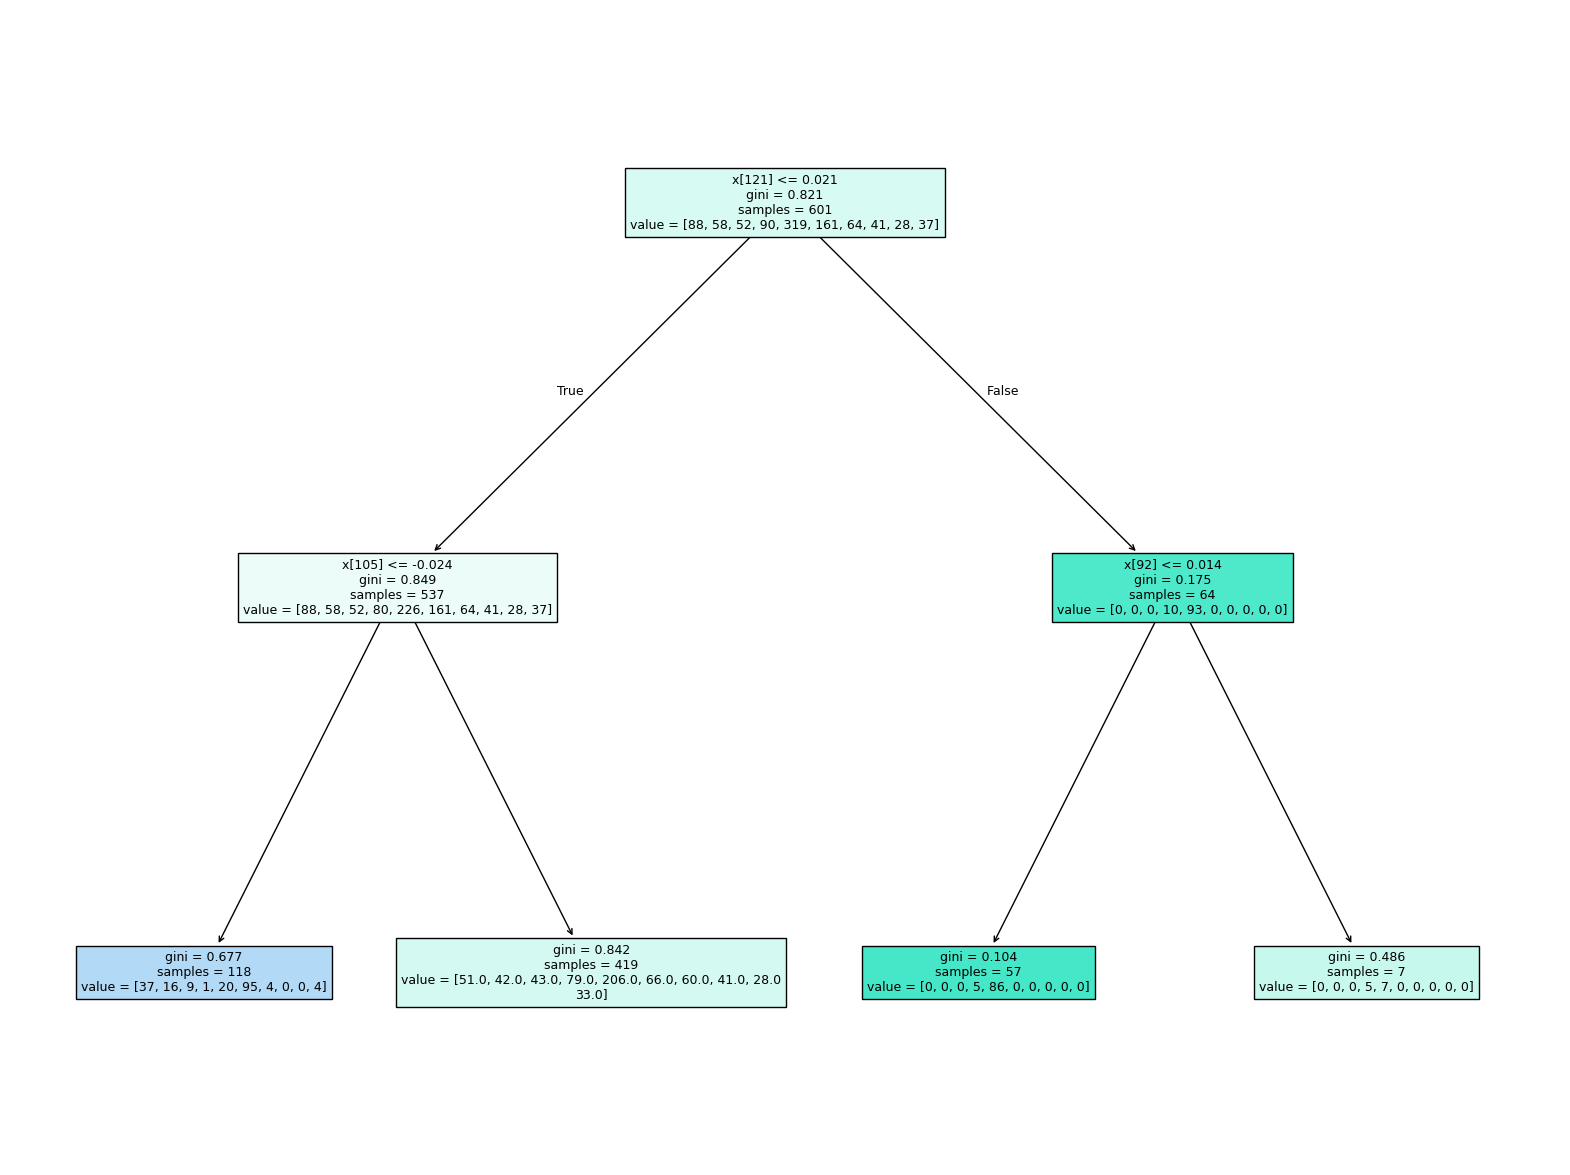

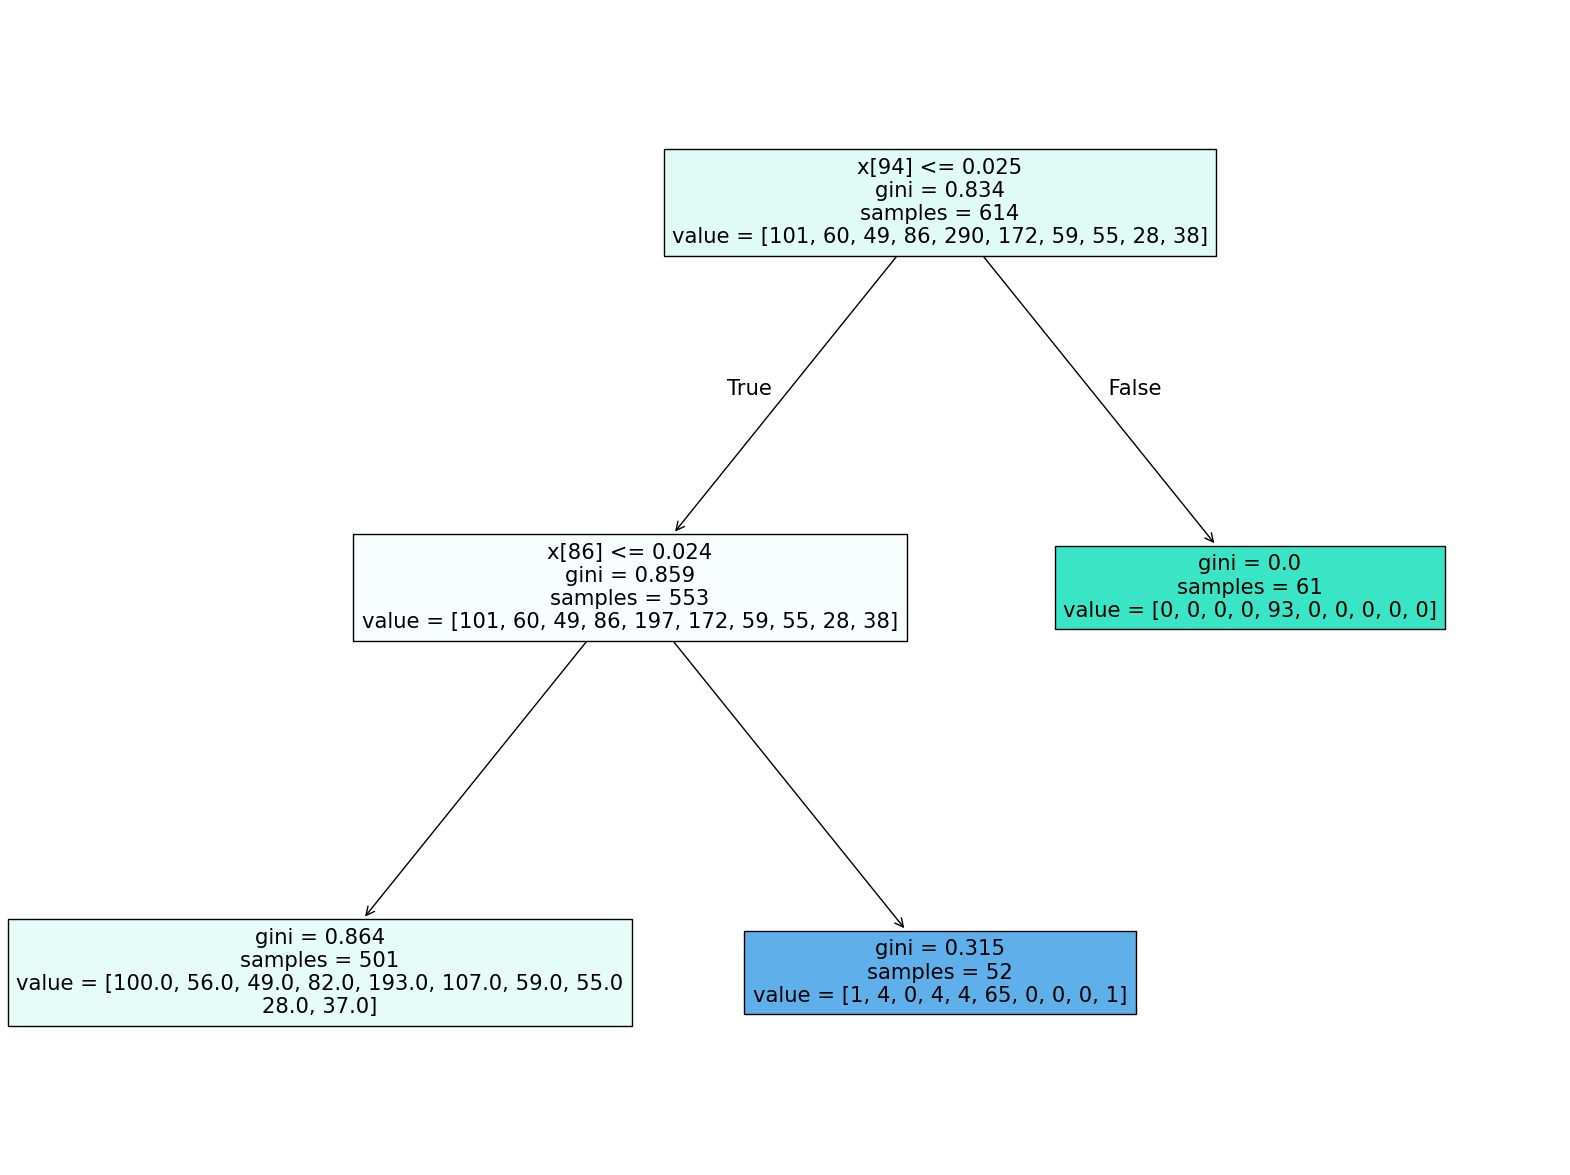

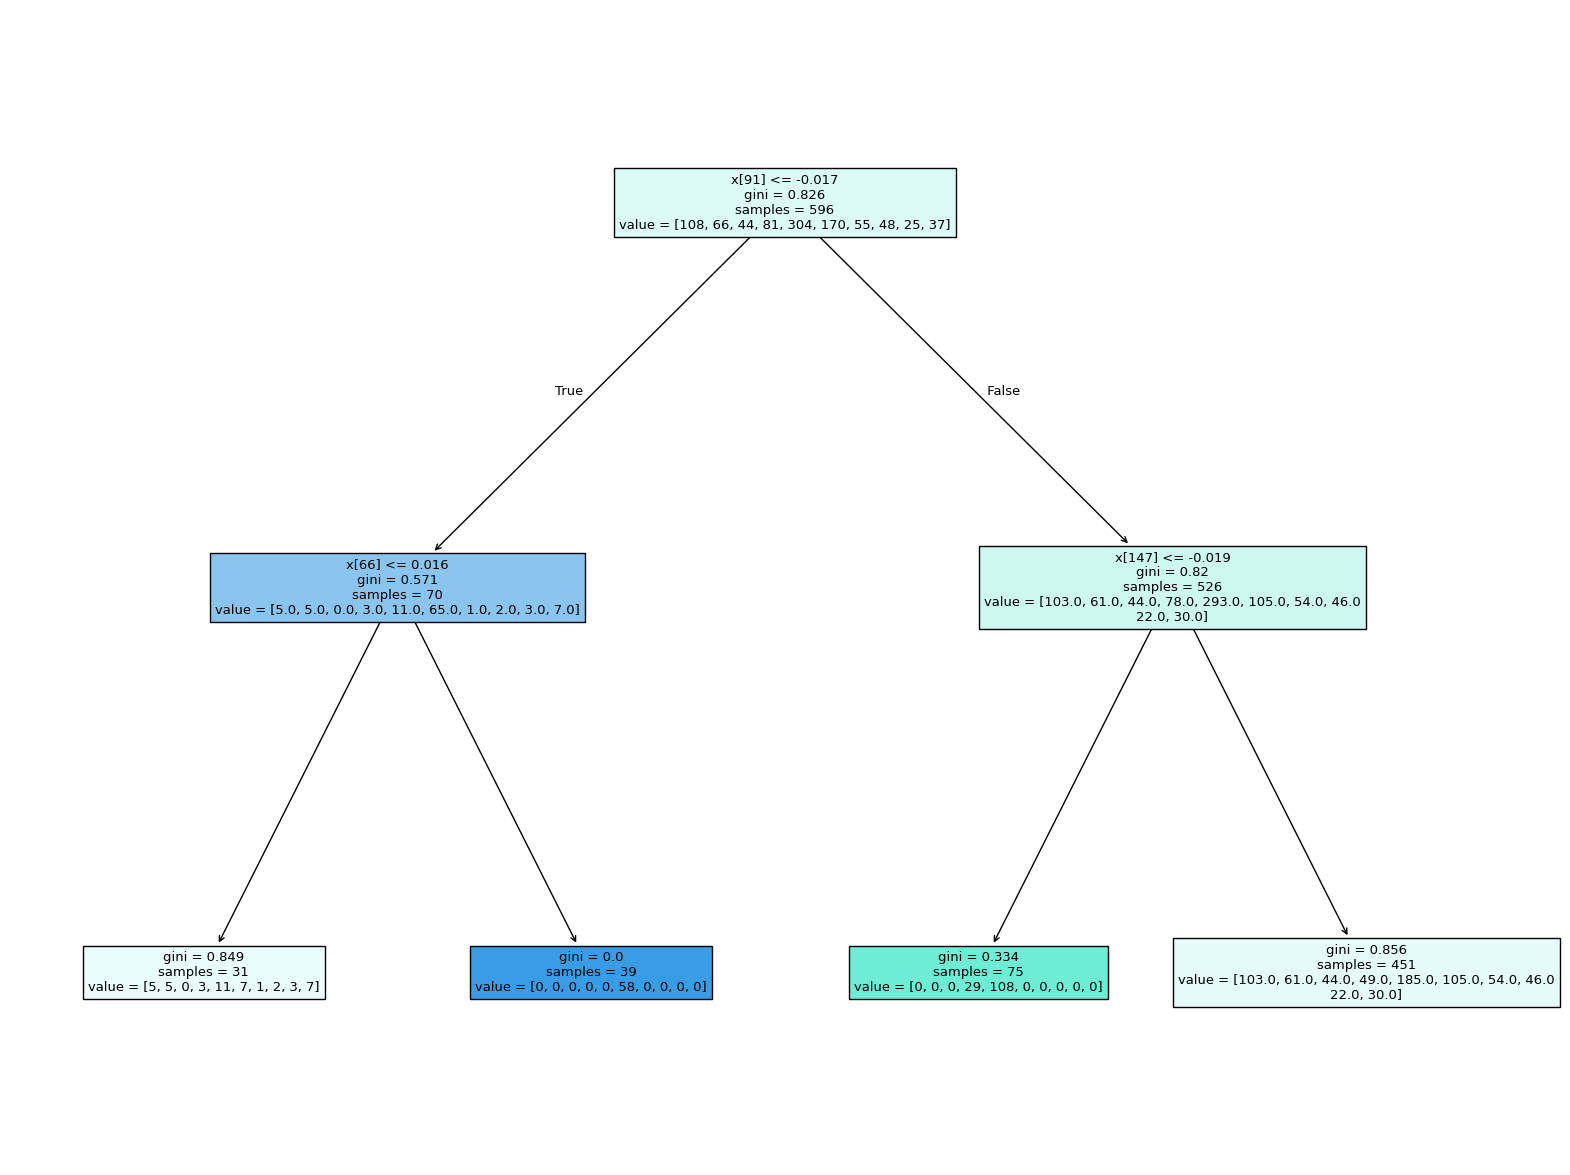

In [20]:
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[0], filled=True) 
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[4], filled=True) 
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[42], filled=True) 

It's important to note that not every decision pertains to those two classes - but the majority do, and in a classifier such as random forests where the majority wins out, that means that on the whole these smaller classes get lost.

Like SVMs, we can use class weights to help overcome this, and this will help even in the case of very shallow trees.

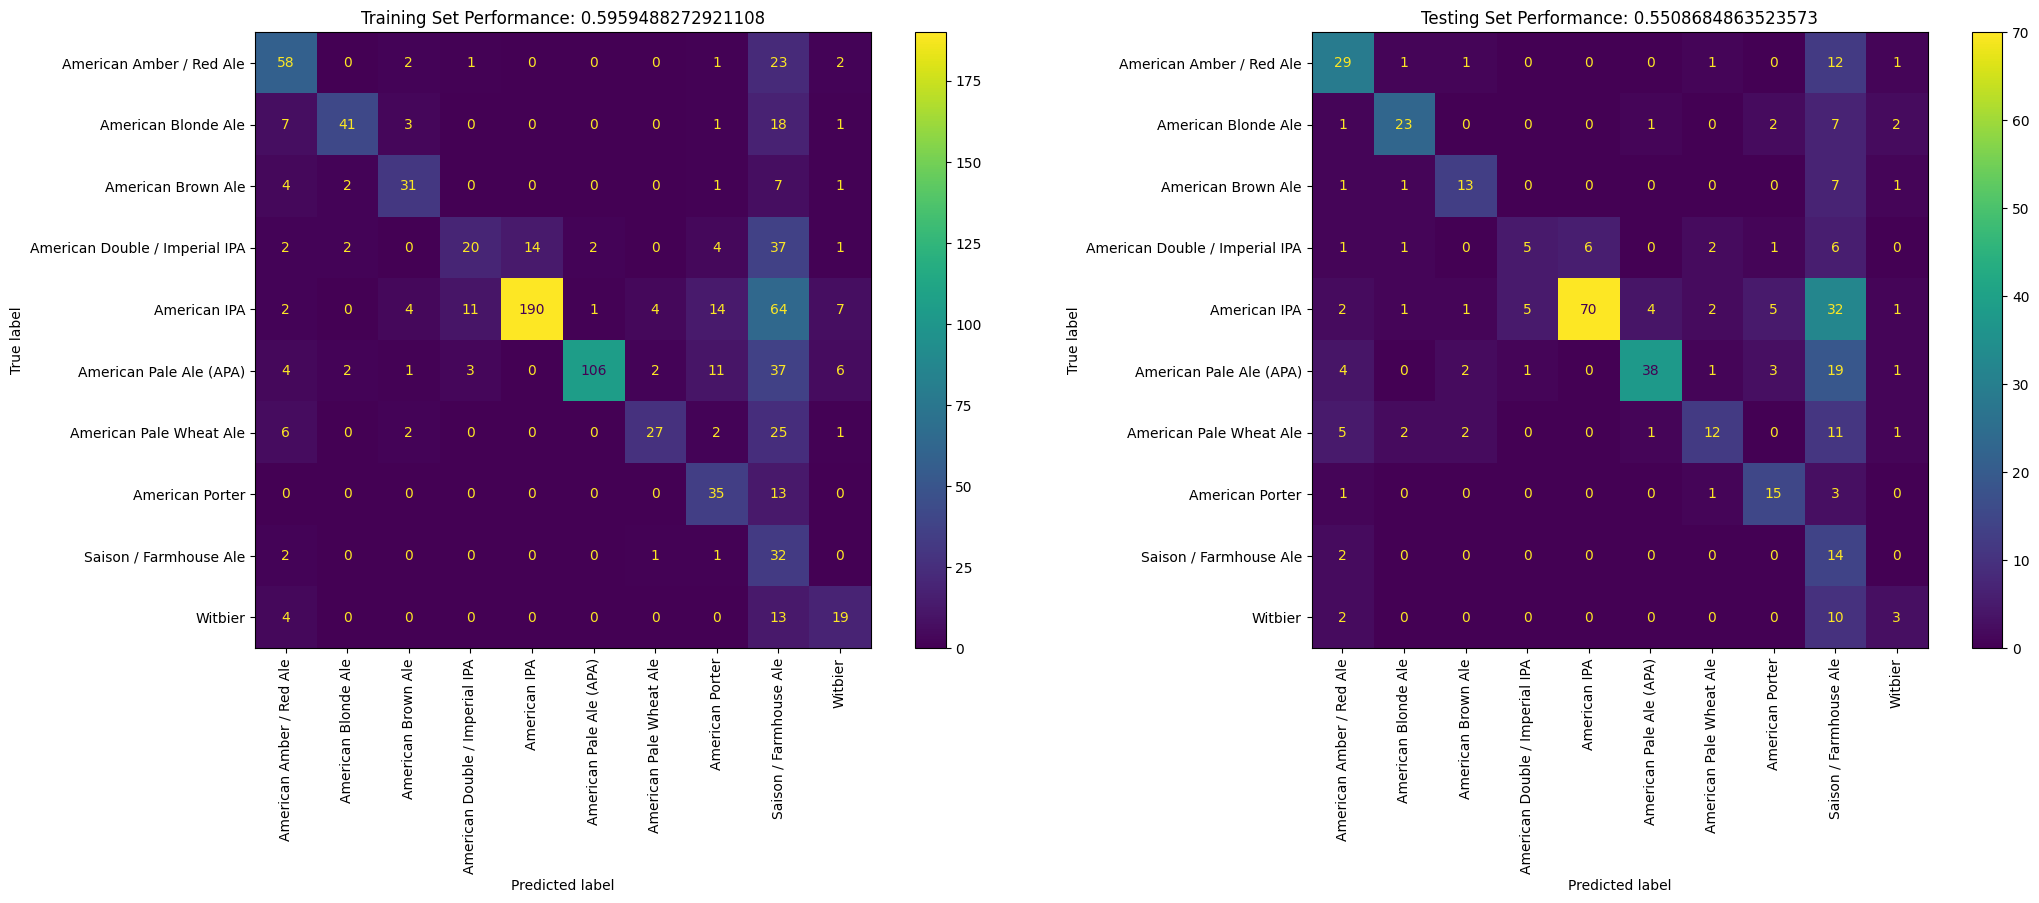

In [21]:
rf = RandomForestClassifier(n_estimators=250, max_depth=2, random_state=0, class_weight='balanced_subsample')
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

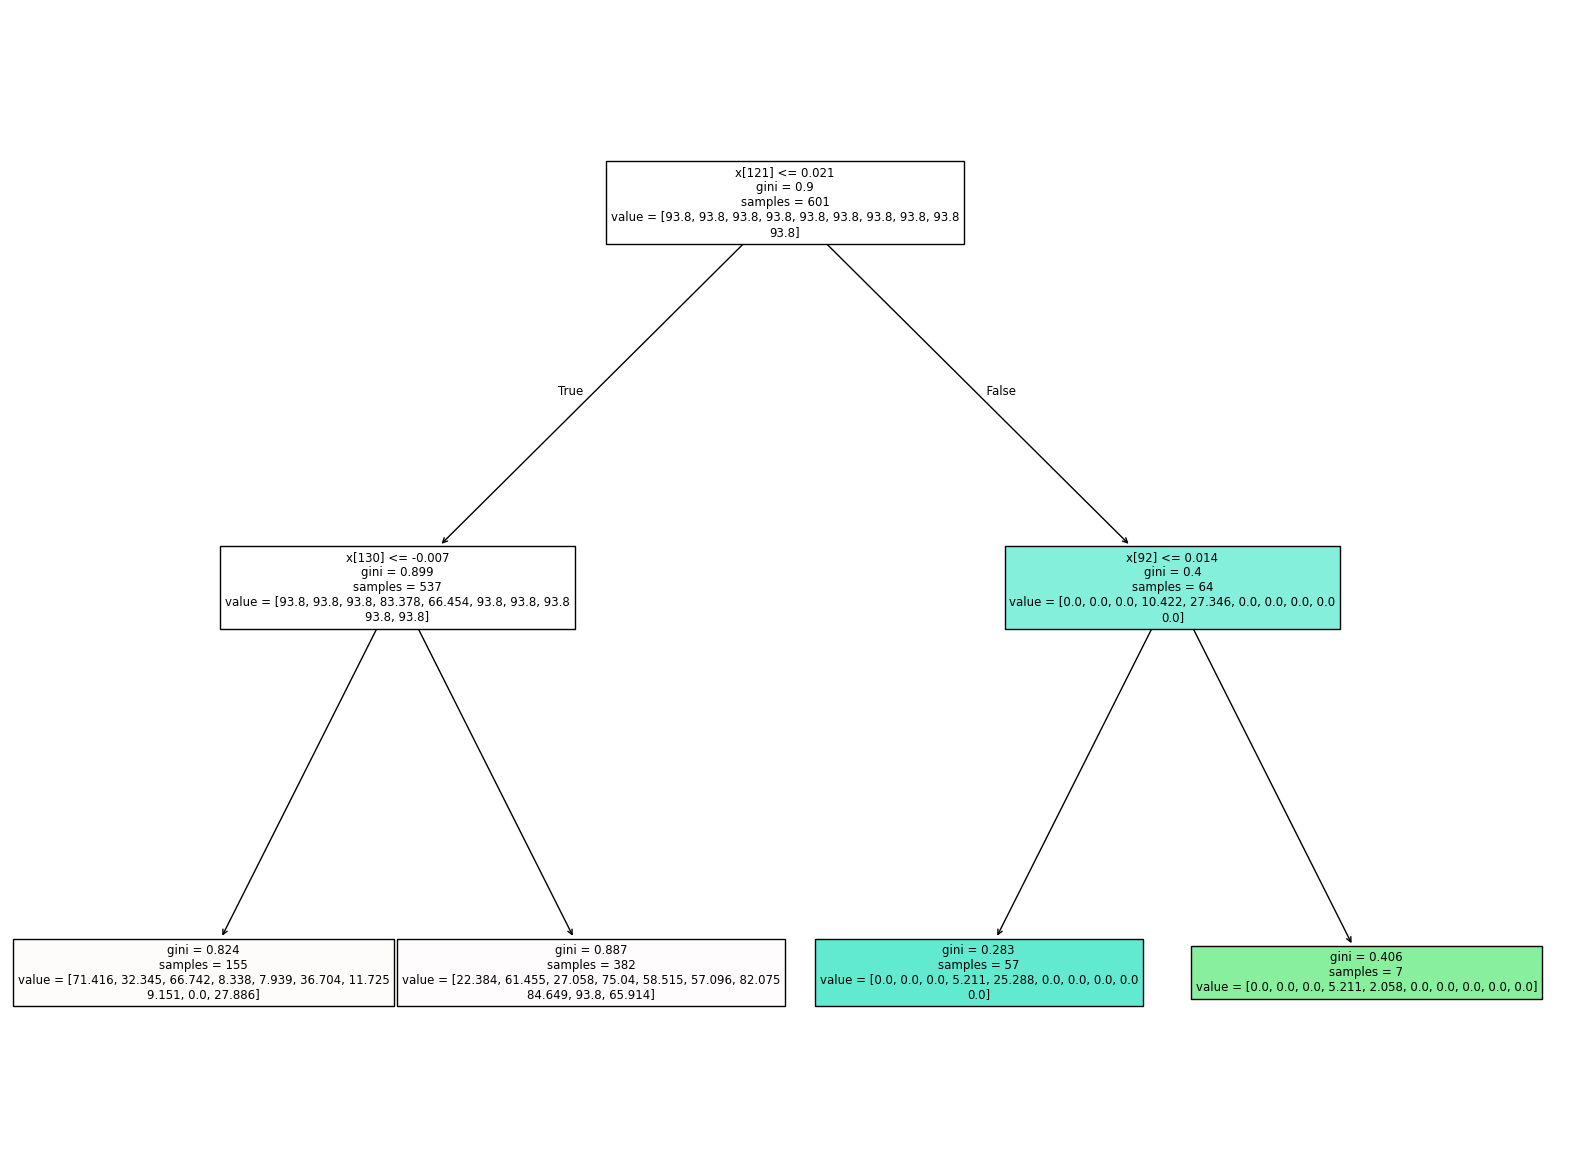

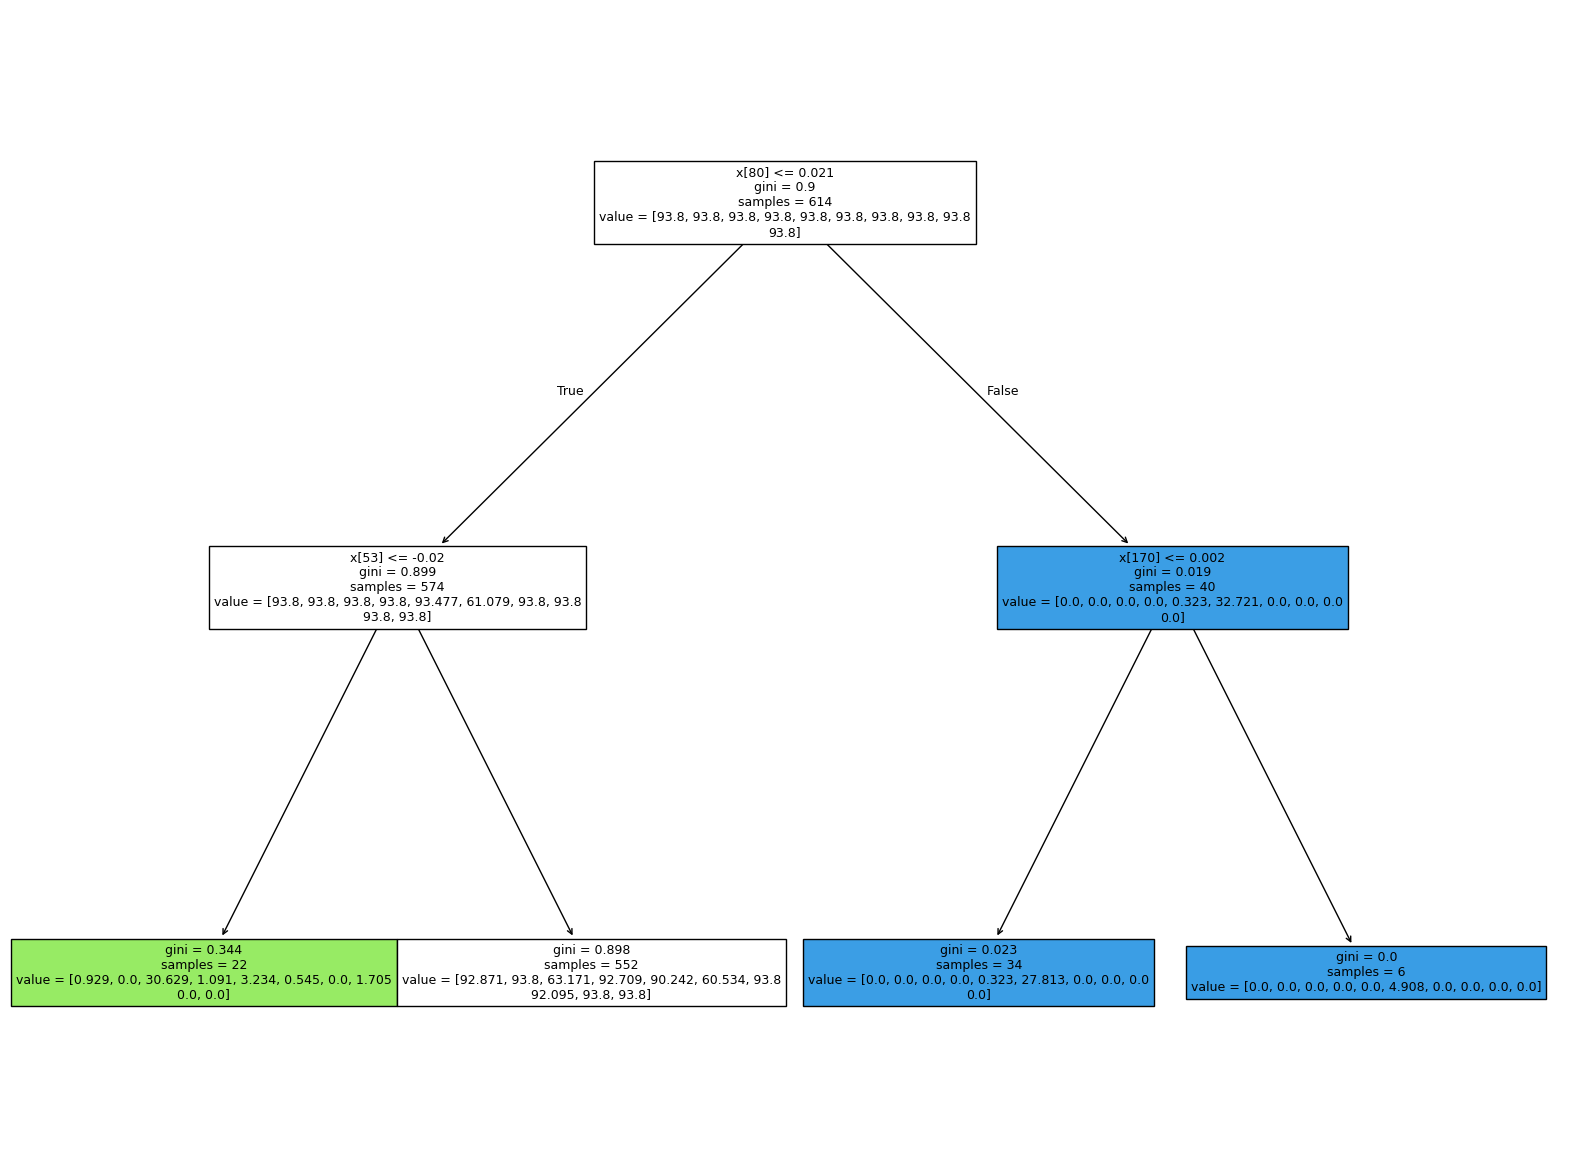

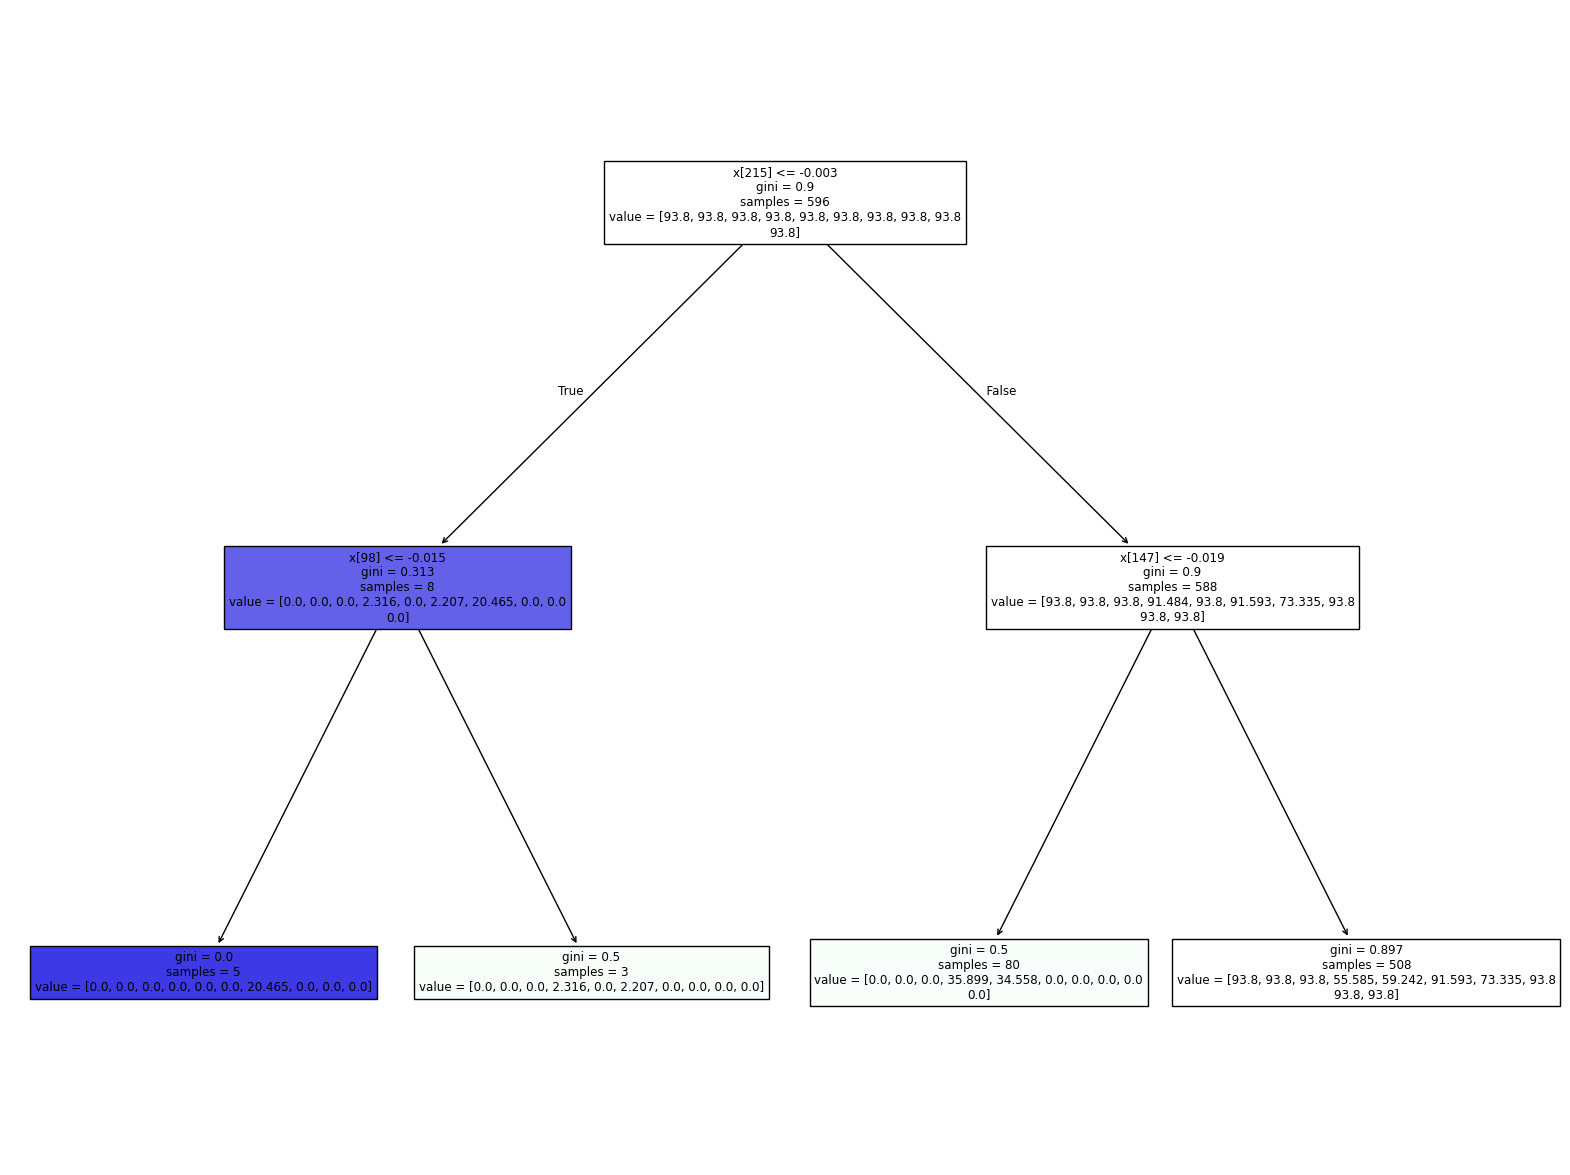

In [22]:
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[0], filled=True) 
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[4], filled=True) 
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(rf.estimators_[42], filled=True) 

Even though our trees are still tiny, the fact that we are now forcing the model to pay attention to all classes helps. We can see we get much greater diversity in our decisions, and thus we can classify all classes, to some extent. However, we will get better performance again if we increase our depth.

127
89
70


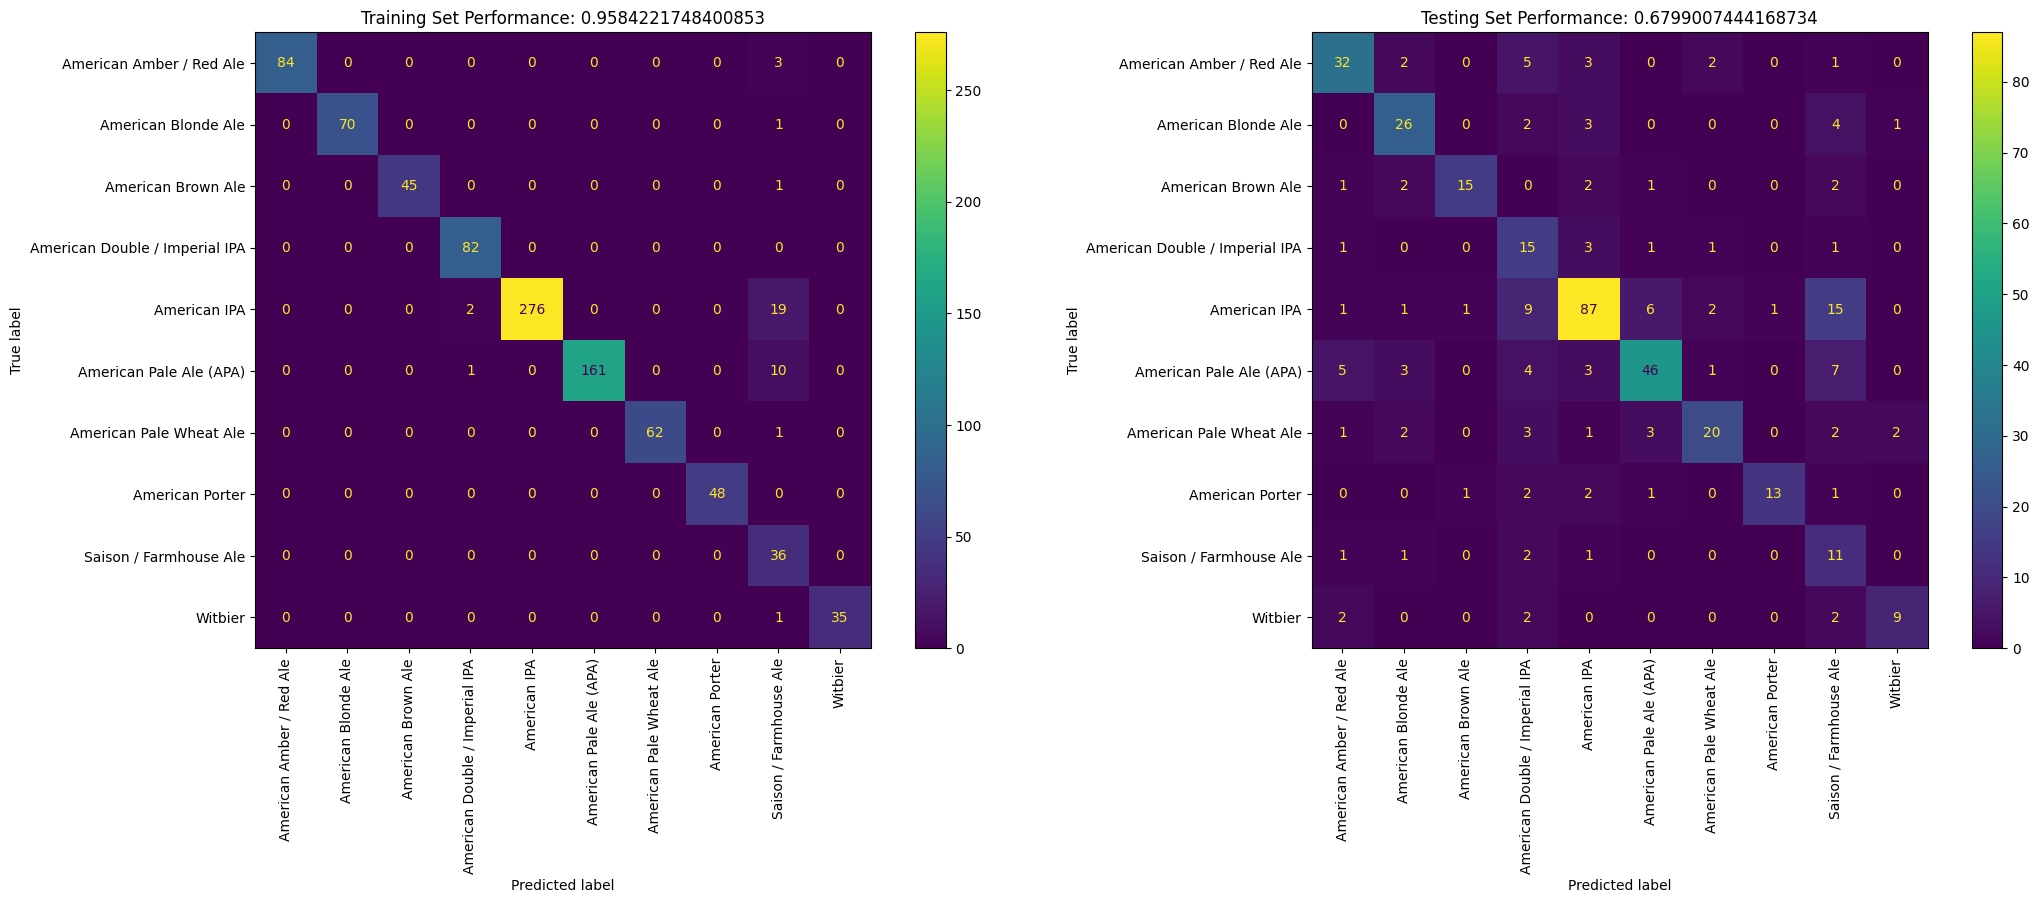

In [23]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0, class_weight='balanced_subsample')
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)
print(rf.estimators_[0].tree_.n_leaves)
print(rf.estimators_[4].tree_.n_leaves)
print(rf.estimators_[42].tree_.n_leaves)

Increasing our depth back to what we had before, we can see performance is improved and we're doing much better on the minority classes. Note that the overall accuracy is down a bit, as we are now less accurate on the majority classes (and as they make up more of the data, performance drops). Also of note is the depth of our trees. For trees 15 decisions deep, the maximum number of leaves (end points) is $2^{15} = 32768$, we can see we fall well short of that, which is to be expected. Visualising the tree, we can see that some branches get quite deep, others don't. This is to be expected, but having that larger maximum depth allows the tree to get to a point where each leaf more likely to contain samples of just a single class.

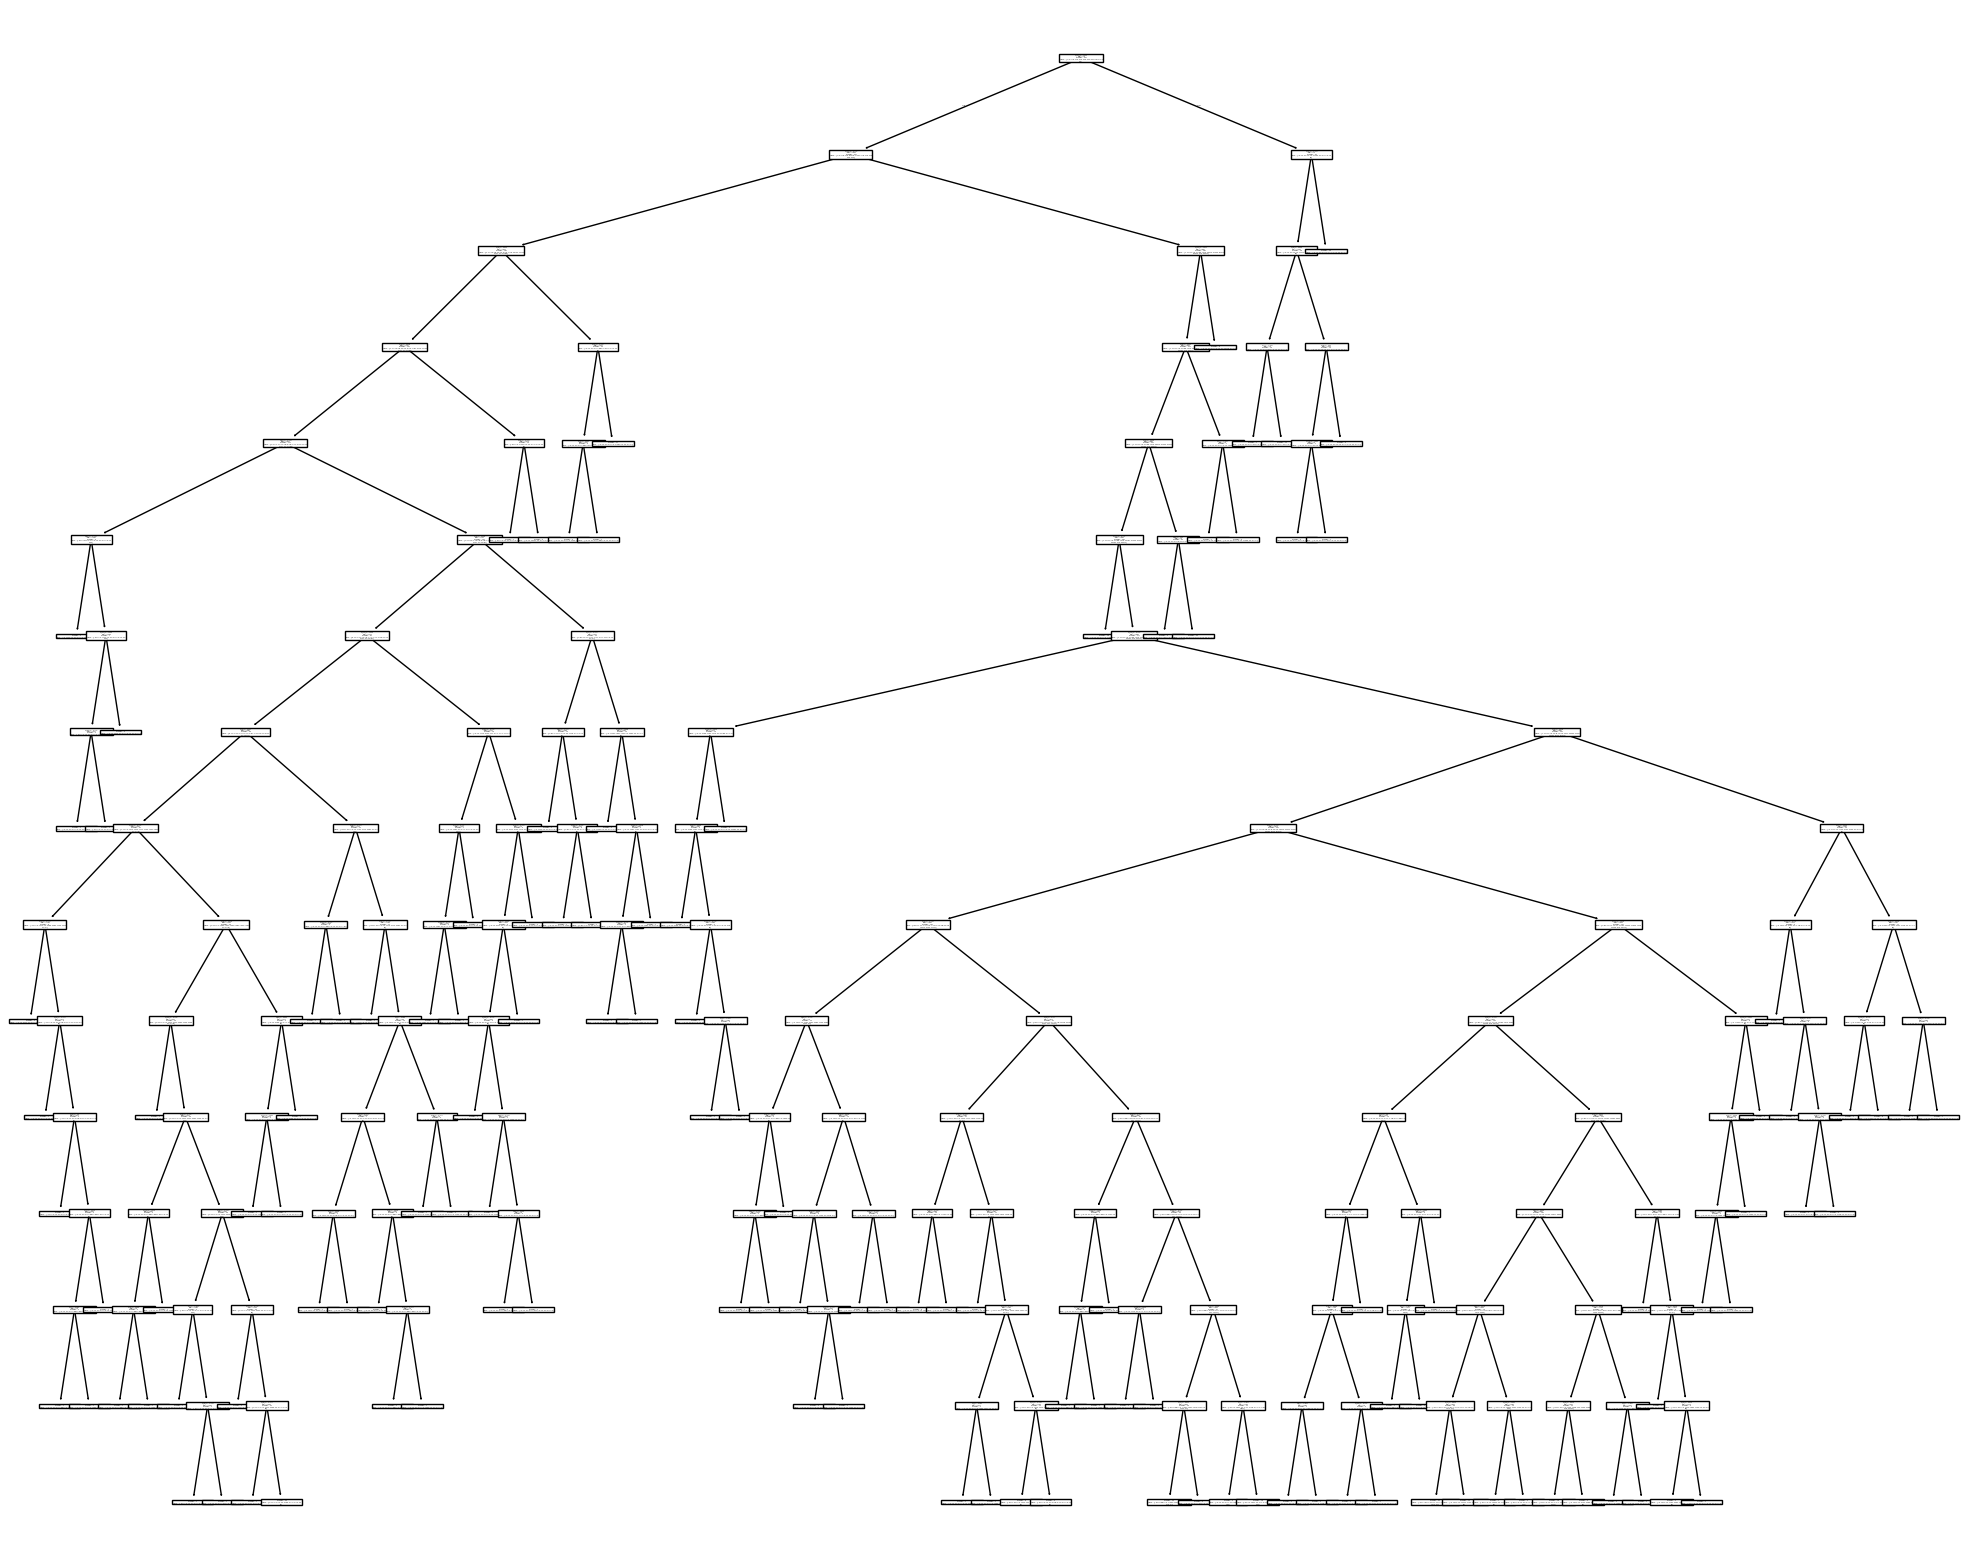

In [24]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(rf.estimators_[0]) 

One final point to note is that we can weight our classes in two ways:
* balanced_subsample, which is what we did above where the distribution of the sample used to train each tree determines the weights (i.e. each tree in the forest will have different weights)
* balanced, where the sample weights are calculated over the whole dataset and then used for each tree

You probably won't see a lot of difference between these except in cases where classes are sufficiently scarce such that the distribution of classes between samples changes, or some classes are not even in all samples.

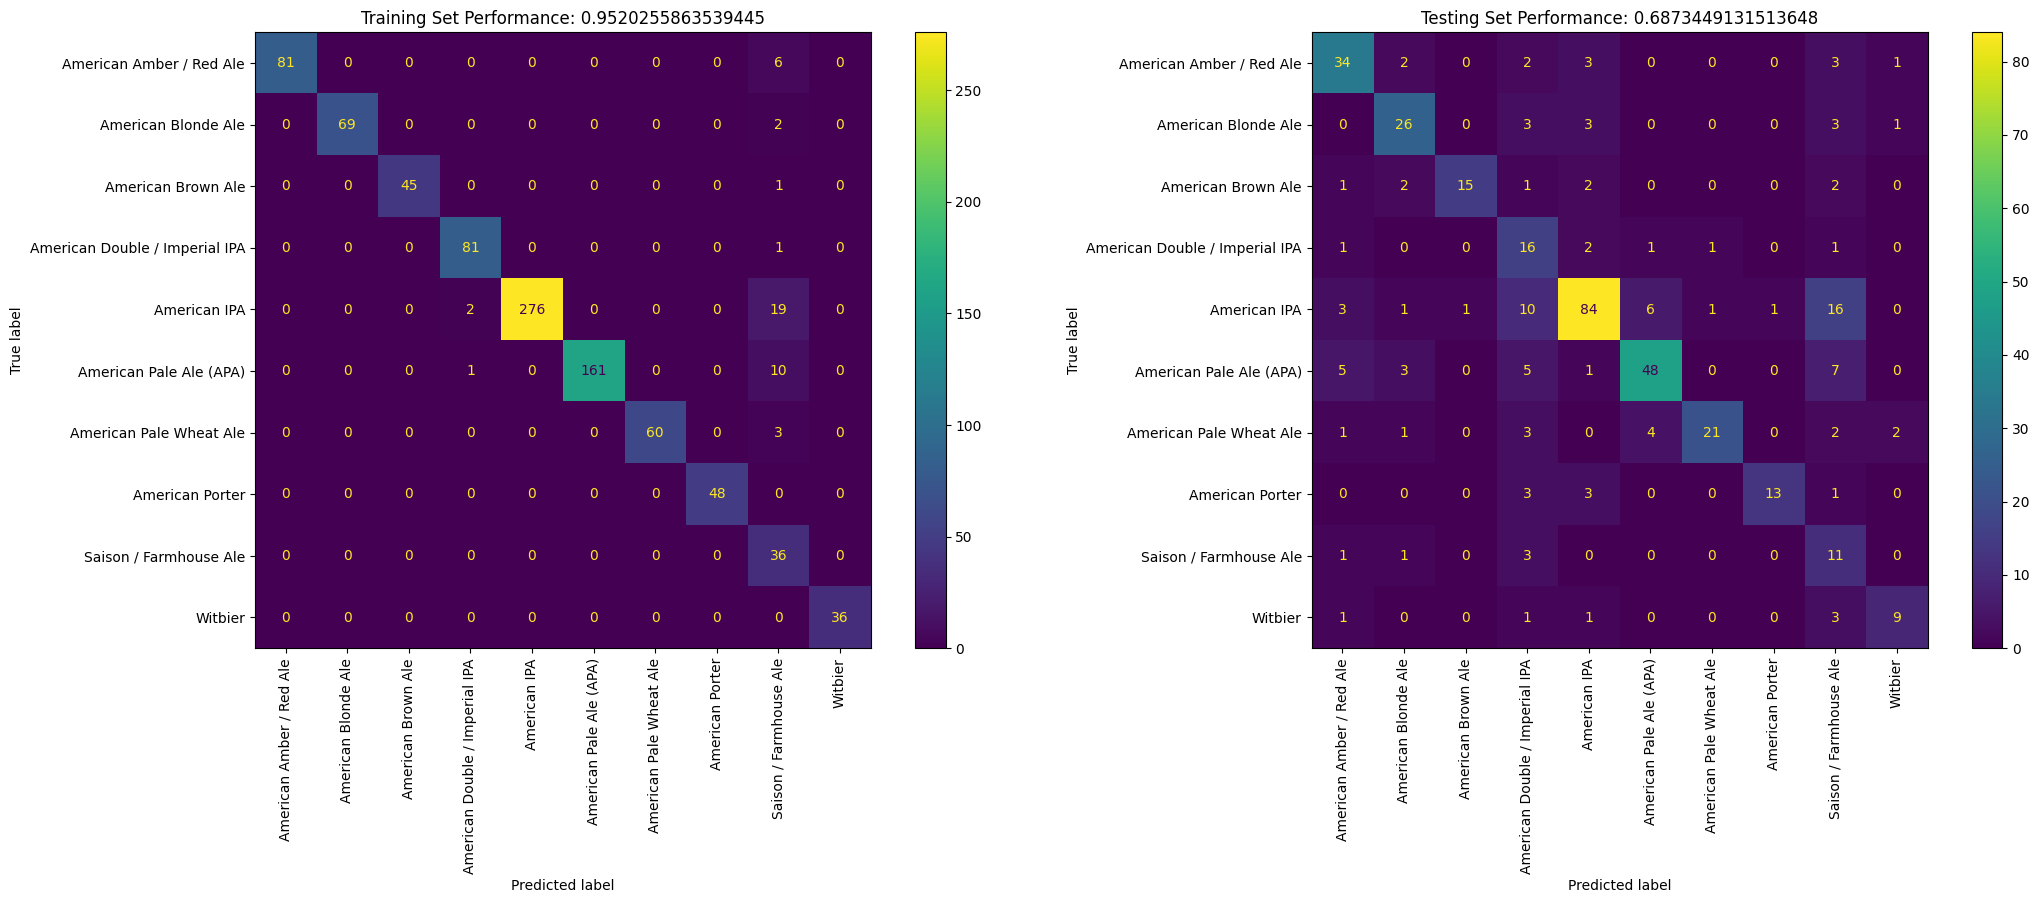

In [25]:
rf = RandomForestClassifier(n_estimators=250, max_depth=15, random_state=0, class_weight='balanced')
rf.fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

## What About Other Feature Encodings?

How we represent the data has a huge impact on how well any model works. Above, we used a word embedding model to transform each word into a vector, and then appended all of these vectors to get a sequence. To make sure that all inputs were the same length, we padded sequences as needed, and removed really long names too. This whole approach has some limitations, starting with:
* It imposes some really strict order information on the representation
* We have to pad samples (adding redundant information), or remove samples (losing data) to get everything the same length

There is another feature representation out there called Bag of Words. I'm not going to go into details on that here (it's outside of scope, and there's a bonus example in `CAB420_Classification_Bonus_Example_BOW.ipnb`), but compared to what we did above Bag of Words will:
* Transform variable length text passages into a fixed length representation, so no need for padding, cropping, or any other things like that
* Completely ignore order informaton
* Potentially lead to a very, very large feature representation

In brief, bag of words does this by building a dictionary of words, and then using this to encode each sample (i.e. beer name) into a histogram, showing what words occur in the same. None of the above is to say that Bag of Words is better (or worse) than the word embeddings we used above - but different feature encoding will have different performance, and different classifiers will be better suited to different feature encodings. 

With that out the way let's quickly throw a bag of words feature encoding into an SVM. One thing to note here is that our input data is just the names of the beers, not the tokenised text, or the embeddings. This is why we created this above. 

In [26]:
# create Bag of Words encoding object
count_vect = CountVectorizer(min_df=0.0001, max_df=0.25)
# fit to training data, and apply to training data
X_train_counts = count_vect.fit_transform(X_train_names)
# apply to the test data
X_test_counts = count_vect.transform(X_test_names)

# shape of the data, note that our representation is quite high dimensionsal
print(X_train_counts.shape)
print(X_test_counts.shape)

(938, 1098)
(403, 1098)


For simplicity, we'll fit a simple 1v1 SVM. We won't even use class weights. The equivilent SVM above achieved about 64% on the test set, and our best performance across all models so far (noting that we're not really trying to optimise anything) is about 72%.

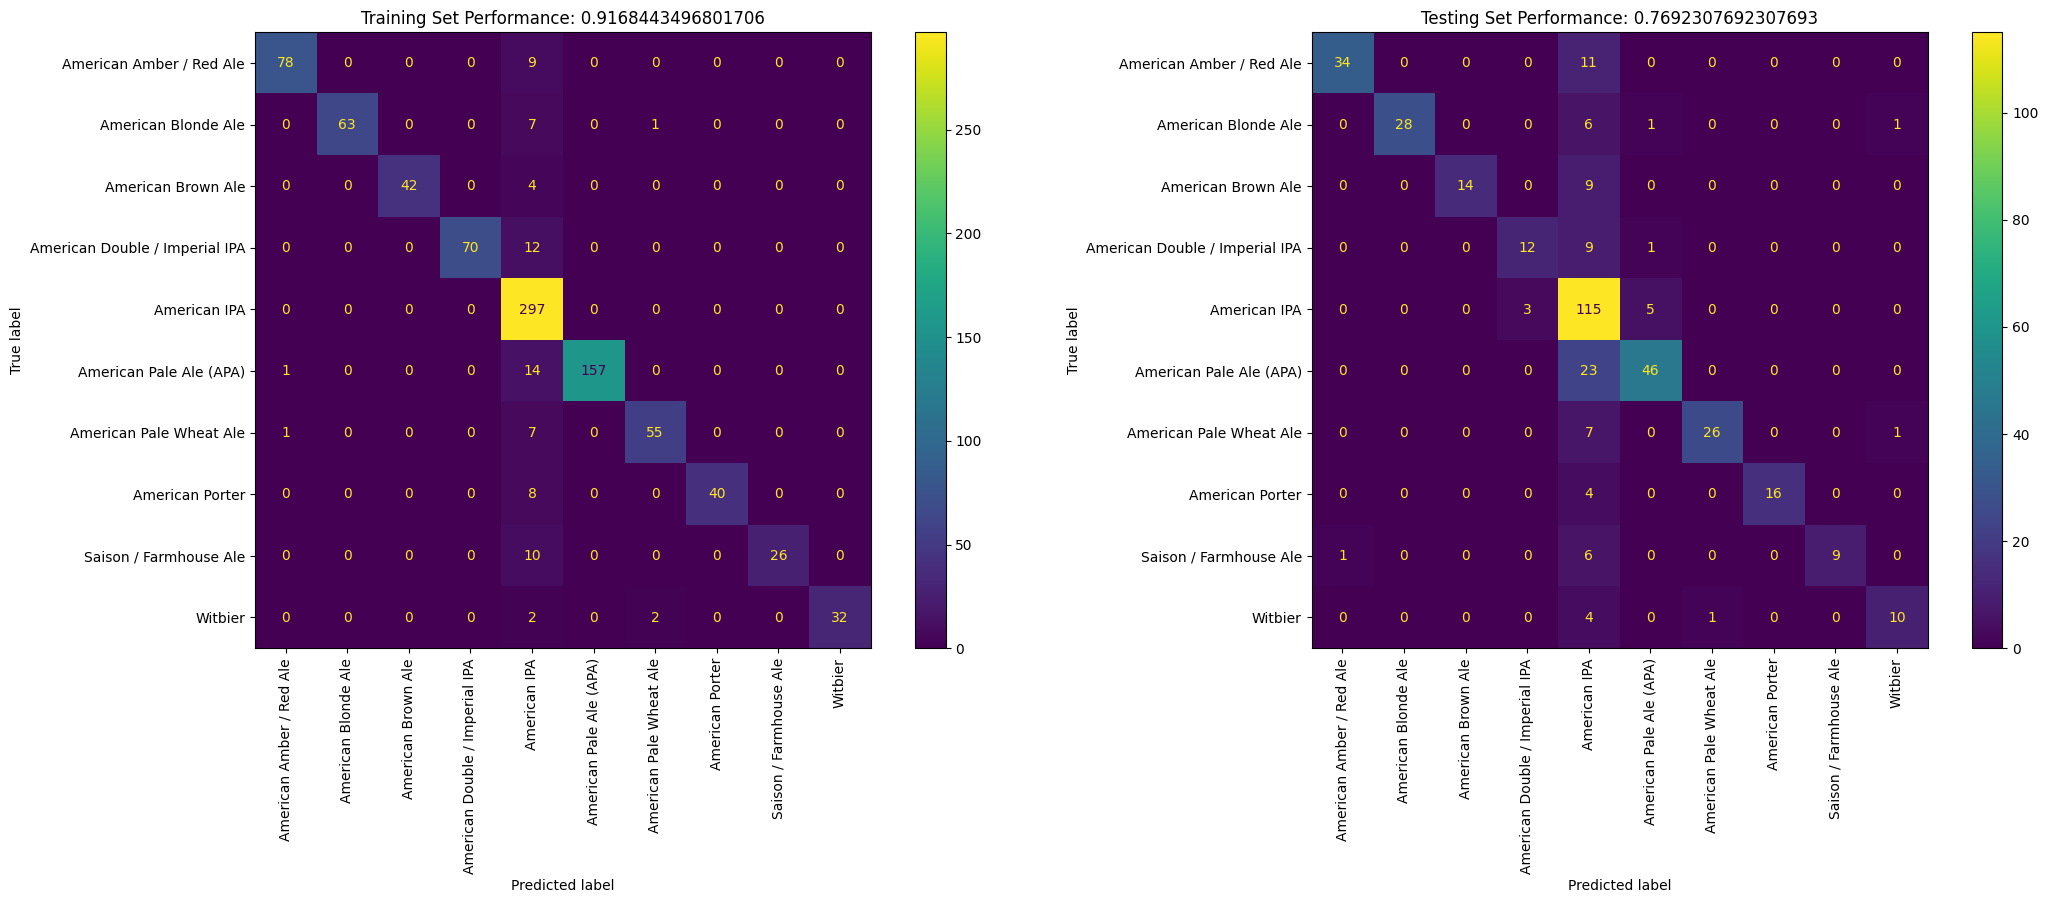

In [27]:
onevsone_svm = OneVsOneClassifier(SVC())
onevsone_svm.fit(X_train_counts, Y_train)
eval_model(onevsone_svm, X_train_counts, Y_train, X_test_counts, Y_test)

Here, we get almost 77% on the test set. This is the best result by a good margin, and is not the result of anything we've done in terms of turning the classifier settings, but is the result of picking a different data representation.

We could really dive into the weeds here now and try tuning up our bag of words extraction in combination with the classifier, and get some further gains, but that's outside the scope. The important thing to take from this is that your data representation matters, and getting this right can greatly simplify the task of actually learning the model.

## What About Other Classification Methods?
There are a ton of other methods in sklearn (and python in general) for this task. A really good and brief overview for sklearn is [here](https://scikit-learn.org/stable/modules/multiclass.html), which breaks down with methods are inherently multi-class, and what support others have.

Remember, even if a method is nominally a binary method, using either a one vs one or one vs all encoding will allow it to work in a multi-class environment.

## Final Thoughts
In this example we've seen that:
* CKNN can be directly applied for multi-class classification, though care needs to be taken with hyper parameters such as the number of neighbours as per usual.
* Random forests also directly work for multi-class classification, and again, hyper parameters need to be considered based on the characteristics of the problem
* SVMs (and other binary classifiers such as logistic regression) need to use a multi-class encoding scheme to extend to multi-class problems, however python handles this pretty seamlessly - albeit using different approaches for different classifier types.
* There are two main ways to construct the ensemble, one vs one will train a classifier for each possible pair of classes; one vs all will train one classifier per class, with the aim of separating the target class from everything else. One vs one models tend to perform better in the presence of class imbalance issues, but are slower to train and will take up more memory.
* By default with sklean, a one vs one model will be used when dealing with multi-class data, while logistic regression will default to a one vs all. In either case, we can use additional features in sklearn to do things differently
* With a multi-class SVM, class imbalance can be managed with a cost matrix. While we can provide this manually if we want, python will also just work it out for us on the fly

We've also touched on extracting word features for use in classification. This has many powerful applications including areas such as sentiment classification, translation, and question answering. We've considered (in brief) a couple of different feature representations (word embeddings and bag of words) here too. One of these is not better than the other, they are both appropriate in different contexts, but the important thing to keep in mind is that different feature extraction methods will lead to different results, and it is worth considering what you need for your task. That said, feature representations are not in CAB420's main scope, though this is something that you may need to consider in Assignment 2 depending on what you choose to do.

### Things to Explore

There are a lot of things to continue to explore with this example. In particular:
* Change the parameters around our data extraction. You could use bigger (or smaller) embeddings, use a pre-trained embedding, or allow more (or less) classes.
* Try to optimise the models. Use a hyper-parameter search, or just play around with the parameters, and see what sort of accuracy you can achieve.
* Do more with the Bag of Words representation (see `CAB420_Classification_Bonus_Example_BOW.ipnb` for more info), and see how using bag of words impacts performance.
* Try a different type of classifier. Most (all?) classifiers in SKLearn have a very similar API, so there's no additional coding challenges in swapping out models - just a different set of hyper-parameters to deal with.